<a href="https://colab.research.google.com/github/sasun8820/NLP/blob/main/NLP_TSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TSM, without sentiment score graph

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/5067 NLP/stock_yfinance_data.csv")
train = pd.read_csv("/content/drive/MyDrive/5067 NLP/stock_tweets.csv")

print (df.head())
print (train.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name  
0  53868000       TSLA  
1  51094200       TSLA  
2  91449900       TSLA  
3  55297800       TSLA  
4  43898400       TSLA  
                        Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name C

In [ ]:
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stat

In [ ]:
mkdir ~/nltk_data

In [ ]:
nltk.data.path.append("~/nltk_data")
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
print(nltk.data.path)

['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '~/nltk_data']


In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

##  Basic Feature Extraction

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/5067 NLP/stock_tweets.csv")

In [ ]:
dataset = dataset[dataset['Stock Name'] == 'TSM']
train = train[train['Stock Name'] == 'TSM']

In [ ]:
train.shape

(11034, 4)

## Handling User Mentions and Hashtags

In [ ]:
import re

# Define functions to extract user mentions and hashtags
def extract_user_mentions(text):
    # Use regex to find user mentions (e.g., @username)
    user_mentions = re.findall(r'@(\w+)', text)
    return user_mentions

def extract_hashtags(text):
    # Use regex to find hashtags (e.g., #topic)
    hashtags = re.findall(r'#(\w+)', text)
    return hashtags

# Apply the functions to the 'body' column
train['user_mentions'] = train['Tweet'].apply(extract_user_mentions)
train['hashtags'] = train['Tweet'].apply(extract_hashtags)

In [ ]:
train.head()

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags
62741,2022-09-29 22:23:02+00:00,EG vs FNC is a deadly matchup.\n\nEG using the...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[]
62742,2022-09-29 21:50:16+00:00,@BTSsmash @coinbase @Panda_Plup @LiquidHbox @T...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[]
62743,2022-09-29 21:13:20+00:00,I keep looking at the current #R6NAL standings...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[SoniqsEsports, TSM, XSET, MirageSportE, DarkZ...",[R6NAL]
62744,2022-09-29 19:35:26+00:00,@BTSsmash @coinbase @Panda_Plup @LiquidHbox @T...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[]
62745,2022-09-29 19:19:05+00:00,@joe1chief @BTSsmash @coinbase @Panda_Plup @Li...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[joe1chief, BTSsmash, coinbase, Panda_Plup, Li...",[]


## Expand Contractions

In [ ]:
# Define a dictionary of common contractions and their expansions
contraction_dict = {
    "ain't": "are not",
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he's": "he is",
    "he'll": "he will",
    "he'd": "he would",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "mustn't": "must not",
    "shan't": "shall not",
    "she's": "she is",
    "she'll": "she will",
    "she'd": "she would",
    "should've": "should have",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they're": "they are",
    "they'll": "they will",
    "they'd": "they would",
    "wasn't": "was not",
    "we're": "we are",
    "we'll": "we will",
    "we'd": "we would",
    "weren't": "were not",
    "what's": "what is",
    "won't": "will not",
    "wouldn't": "would not",
    "you're": "you are",
    "you'll": "you will",
    "you'd": "you would",
    # Add more contractions and expansions as needed
}

# Define a function to expand contractions using the dictionary
def expand_contractions_manual(text):
    words = text.split()
    expanded_words = [contraction_dict[word] if word in contraction_dict else word for word in words]
    return ' '.join(expanded_words)

# Apply the function to the 'text' column
train['Tweet'] = train['Tweet'].apply(expand_contractions_manual)

In [ ]:
train.head()

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags
62741,2022-09-29 22:23:02+00:00,EG vs FNC is a deadly matchup. EG using their ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[]
62742,2022-09-29 21:50:16+00:00,@BTSsmash @coinbase @Panda_Plup @LiquidHbox @T...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[]
62743,2022-09-29 21:13:20+00:00,I keep looking at the current #R6NAL standings...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[SoniqsEsports, TSM, XSET, MirageSportE, DarkZ...",[R6NAL]
62744,2022-09-29 19:35:26+00:00,@BTSsmash @coinbase @Panda_Plup @LiquidHbox @T...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[]
62745,2022-09-29 19:19:05+00:00,@joe1chief @BTSsmash @coinbase @Panda_Plup @Li...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[joe1chief, BTSsmash, coinbase, Panda_Plup, Li...",[]


## Lower Case

In [ ]:
train['Tweet'] = train['Tweet'].str.lower()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11034 entries, 62741 to 73774
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           11034 non-null  object
 1   Tweet          11034 non-null  object
 2   Stock Name     11034 non-null  object
 3   Company Name   11034 non-null  object
 4   user_mentions  11034 non-null  object
 5   hashtags       11034 non-null  object
dtypes: object(6)
memory usage: 603.4+ KB


In [ ]:
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags
72563,2021-11-05 21:30:00+00:00,🚗 road to pgc ft. @tsm #tsmwin the current tsm...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM, PurdyKurty, luke12PUBG, alowflaylow, pen...","[TSMWIN, PGC2021]"
68043,2022-03-15 16:03:01+00:00,we'll start: @geng,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[GenG],[]
72967,2021-10-27 02:41:37+00:00,@tsm_myth ok motherfucker its on,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM_Myth],[]
73238,2021-10-17 23:35:19+00:00,@cented7 @stretch @tsm_commandment can u pleas...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[Cented7, Stretch, TSM_Commandment, AussieAnti...",[]
68863,2022-02-20 23:30:45+00:00,@tsm @tsm_beaulo @tsm_achieved @chala_r6 @tsm_...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM, TSM_Beaulo, TSM_Achieved, Chala_R6, TSM_...",[]
71673,2021-12-01 05:48:16+00:00,normal people on dec 1st: holidays! vacation! ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[VALORANTChampions]
64552,2022-07-10 03:41:58+00:00,@imperialhal @verhulst @tsm_reps stay mad hate...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[ImperialHal, Verhulst, TSM_Reps]",[]
69360,2022-02-16 11:53:37+00:00,@r6esports @tsm @tsm_achieved one step closer ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[R6esports, TSM, TSM_Achieved]",[]
72792,2021-10-31 23:38:56+00:00,top 5 going in the last game: 1st @bugha @mero...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[bugha, MeroFN, MuzFN, JamperFN, DeyyFN, tragi...",[]
66830,2022-04-23 20:26:57+00:00,@tsm @subroza @corey_ow @rossyua @sevvn @guiii...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM, Subroza, Corey_OW, RossyUA, sevvn, Guiii...",[]


# Remove Punctuations

In [ ]:
# Assuming you have a DataFrame 'train' with a column 'text' containing text data
# Replace 'text' with the actual column name in your dataset

# Define a function to remove punctuation from a text string
def remove_punctuation(text):
    # Use regex to remove all non-alphanumeric characters (including punctuation)
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply the function to the 'text' column
train['Tweet'] = train['Tweet'].apply(remove_punctuation)

In [ ]:
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags
64092,2022-07-28 14:54:39+00:00,tgt ms tsm mu v mcd abbv tgt 88 this wee...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[]
62957,2022-09-17 17:01:07+00:00,happy birthday tsm_achieved a world champion o...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM_ACHIEVED],[TSM]
65325,2022-06-08 21:42:04+00:00,teams i think will make it into franchising n...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[VCT]
71528,2021-12-06 23:53:24+00:00,fnatic tsm when does tsm play,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[FNATIC, TSM]",[]
62931,2022-09-20 10:56:09+00:00,imma do a prediction and no i got no insider i...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[]
66566,2022-04-30 01:09:58+00:00,playing against tsm httpstcol33v1i8yrb,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM],[]
67525,2022-03-27 18:39:41+00:00,cleaning up comms shit tsm says episode 4 is ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[]
70179,2022-01-29 21:05:22+00:00,ggs tsm we lost 02 all good,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM],[]
65657,2022-05-23 17:06:11+00:00,tsm lets gooo,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM],[]
67485,2022-03-28 21:51:57+00:00,trulytenzin tsm put her in coach,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TrulyTenzin, TSM]",[]


##  Remove Special Characters

In [ ]:
# Assuming you have a DataFrame 'train' with a column 'text' containing text data
# Replace 'text' with the actual column name in your dataset

# Define a function to remove special characters from a text string
def remove_special_characters(text):
    # Use regex to remove all non-alphanumeric characters (including special characters)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Apply the function to the 'text' column
train['Tweet'] = train['Tweet'].apply(remove_special_characters)

In [ ]:
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags
64943,2022-06-25 23:20:05+00:00,mia was not missing in action that game ggs tsm,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM],[]
65090,2022-06-20 18:13:31+00:00,celebrating tsmbeaulo 21st birthday last night...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM_Beaulo],[]
62812,2022-09-26 01:31:56+00:00,ceotaku 2022 top 4 after an impressive lower b...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[TSM]
73351,2021-10-13 20:00:32+00:00,so is brtt really better than doublelift http...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[]
73223,2021-10-18 18:03:05+00:00,full time coach part time prophet tsmpojoman ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM_Pojoman],[]
72764,2021-11-01 05:28:48+00:00,stretch cented7 tsmcommandment i feel bad for ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[Stretch, Cented7, TSM_Commandment]",[]
64008,2022-08-01 18:05:26+00:00,gamers8 ft rainbow six begins this week whom d...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[tsm, spacestation, teambds, wylde_gg, falcons...",[Gamers8]
70080,2022-01-30 18:15:02+00:00,parthenaan tsm best of luck parth,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[parthenaan, TSM]",[]
63093,2022-09-09 16:01:46+00:00,tsm csgo players u need to stop being so obses...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM],[]
68683,2022-02-22 17:20:08+00:00,tsm daltoosh the car salesman who slams 2 bang...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM, daltoosh]",[]


##  Removing URLs

In [ ]:
# Assuming you have a DataFrame 'train' with a column 'text' containing text data
# Replace 'text' with the actual column name in your dataset

# Define a function to remove URLs from a text string
def remove_urls(text):
    # Use regex to remove URLs from the text
    text = re.sub(r'http\S+|www.\S+', '', text)
    return text

# Apply the function to the 'text' column
train['Tweet'] = train['Tweet'].apply(remove_urls)

## Removing words and digits containing digits

In [ ]:
# Assuming you have a DataFrame 'train' with a column 'text' containing text data
# Replace 'text' with the actual column name in your dataset

# Define a function to remove words and digits containing digits from a text string
def remove_words_with_digits(text):
    # Use regex to remove words and digits containing digits from the text
    text = re.sub(r'\b\w*\d\w*\b', '', text)
    return text

# Apply the function to the 'text' column
train['Tweet'] = train['Tweet'].apply(remove_words_with_digits)

In [ ]:
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags
66978,2022-04-19 20:47:45+00:00,i have seenheard some shit that crosses a line...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[]
67758,2022-03-21 17:42:15+00:00,tsmalbralelie does this mean we playin ranked ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM_Albralelie],[]
72641,2021-11-03 23:55:37+00:00,nmplol sodapoppintv hasanthehun xqc thewillnef...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[nmplol, Sodapoppintv, hasanthehun, xQc, TheWi...",[]
62868,2022-09-21 21:54:07+00:00,absolutely insane win for tsm keep counting u...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[]
70639,2022-01-17 17:45:02+00:00,statement from tsm india on passport issue for...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],"[pmgc2021, pmgc]"
70795,2022-01-09 12:12:43+00:00,tsmleffen poki got time to pay you now you wil...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM_Leffen],[]
63018,2022-09-13 22:43:13+00:00,ggs to tsm we lose pretty inexcusable that i ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM],[]
67702,2022-03-23 02:23:13+00:00,seeeeeeeesh some crazy games and good laughs t...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM, ImperialHal, Verhulst, TSM_Reps, pandxrz...",[BFCAPEX]
63334,2022-08-29 22:34:26+00:00,myth tsm were birdmanning you,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[Myth_],[]
65620,2022-05-24 20:32:32+00:00,tsm welcome,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM, 1ceStream]",[]


## Tokenization

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize

# Assuming 'train' is your DataFrame and 'body' is the text column to tokenize
train['tweet_tokens'] = train['Tweet'].apply(word_tokenize)

In [ ]:
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens
62868,2022-09-21 21:54:07+00:00,absolutely insane win for tsm keep counting u...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[absolutely, insane, win, for, tsm, keep, coun..."
70667,2022-01-15 19:45:08+00:00,tsm reetlol fortnite lets gooo welcome,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM, Reetlol]",[],"[tsm, reetlol, fortnite, lets, gooo, welcome]"
65398,2022-06-05 01:17:04+00:00,nismoval tsm bald buff,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[NiSMO_VAL, TSM]",[],"[nismoval, tsm, bald, buff]"
64148,2022-07-25 18:15:59+00:00,tsm guiiimond rossyua subroza coreyow sevvn th...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM, Guiiimond, RossyUA, Subroza, Corey_OW, s...",[],"[tsm, guiiimond, rossyua, subroza, coreyow, se..."
66954,2022-04-20 21:57:57+00:00,lecwooloo new tsm mid new mad mid new fnc ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[LEC_Wooloo],[],"[lecwooloo, new, tsm, mid, new, mad, mid, new,..."
69546,2022-02-12 02:36:33+00:00,another gotta get out of this slump sooner or...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM],[],"[another, got, ta, get, out, of, this, slump, ..."
65929,2022-05-15 22:18:55+00:00,tsm oh yeahhhhhh,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[s0mcs, TSM]",[],"[tsm, oh, yeahhhhhh]"
73766,2021-09-30 06:16:48+00:00,qtcinderella you killed it qt,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[qtcinderella],[],"[qtcinderella, you, killed, it, qt]"
72868,2021-10-28 23:26:47+00:00,tsm tsmreginald parthenaan ill miss him but ex...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM, TSMReginald, parthenaan]",[],"[tsm, tsmreginald, parthenaan, ill, miss, him,..."
66512,2022-04-30 21:39:32+00:00,tsmalbralelie under valuing fortify and stayin...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM_Albralelie],[],"[tsmalbralelie, under, valuing, fortify, and, ..."


## Removing Gibberish Words

In [ ]:
from nltk.corpus import words

# Download the NLTK words dataset if you haven't already
nltk.download('words')

# Create a set of English words from the NLTK words dataset
english_words = set(words.words())

# Define a function to remove gibberish words from a list of tokens
def remove_gibberish(tokens):
    cleaned_tokens = [token for token in tokens if token.lower() in english_words]
    return cleaned_tokens

# Assuming 'corrected_tweets' is your corrected tweet column
train['tweet_tokens'] = train['tweet_tokens'].apply(remove_gibberish)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


## Stop Word Removal

In [ ]:
import nltk
nltk.data.path.append('/kaggle/working/nltk_data')

In [ ]:
from nltk.stem import WordNetLemmatizer

# Download the WordNet resource
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/n

True

In [ ]:
!mkdir -p /usr/share/nltk_data/corpora
!wget -P /usr/share/nltk_data/corpora/ http://nltk.org/nltk_data/packages/corpora/wordnet.zip
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

--2023-12-06 18:27:44--  http://nltk.org/nltk_data/packages/corpora/wordnet.zip
Resolving nltk.org (nltk.org)... 15.197.142.173, 3.33.152.147
Connecting to nltk.org (nltk.org)|15.197.142.173|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-12-06 18:27:44 ERROR 404: Not Found.

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [ ]:
import nltk
from nltk.corpus import stopwords

# Assuming 'train' is your DataFrame and 'body_tokens' is the tokenized column
stop_words = set(stopwords.words('english'))

# Define a function to remove stop words from a list of tokens
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# Apply the remove_stopwords function to the 'body_tokens' column
train['tweet_tokens'] = train['tweet_tokens'].apply(remove_stopwords)

In [ ]:
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens
70626,2022-01-18 02:57:33+00:00,focus list for this week rmwl edr f kbh lcid ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[RMWL],"[focus, list, week, f, mu, forget, let, know, ..."
67903,2022-03-18 23:36:05+00:00,about to watch tsm legends might as well watch...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[watch, might, well, watch]"
69284,2022-02-17 17:57:29+00:00,tsmbeaulo brocanadian quality post,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[R6esports, TSM_Beaulo, BroCanadian]",[],"[quality, post]"
68403,2022-02-27 22:31:49+00:00,bjergsen just spill the beans man regi is home...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[Bjergsen],[],"[spill, man, homeless, anyways, whose, fault]"
70163,2022-01-29 23:22:30+00:00,absolute tragedy vs therisenation playing win...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TheRiseNation],[],"[absolute, tragedy, winner, next]"
63347,2022-08-29 05:40:29+00:00,seoldamtwit verhulst imperialhal tsmreps where...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[SeoldamTwit, Verhulst, ImperialHal, TSM_Reps]",[],[photo]
68303,2022-03-03 00:22:01+00:00,most grand finals wins of alltime heading into...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[Safarooniee, Stretch, MackWood1x, Khanada, za...",[],"[grand, heading, stretch]"
63715,2022-08-12 16:59:13+00:00,fuck knockdown shields lmao imperialhal verhulst,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[ImperialHal, Verhulst]",[],[knockdown]
66173,2022-05-06 19:52:02+00:00,tsm tsmdaeda itopataow welcome new people happ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM, TSM_Daeda, ItopataOW]",[],"[welcome, new, people, happy, u]"
67711,2022-03-22 22:37:32+00:00,more win each and we will have tsm vs tsm aca...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[win, academy, monthly, gauntlet, banger]"


## Lemmatization

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

2023-12-06 18:27:58.574440: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 18:27:58.574520: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 18:27:58.574576: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 18:27:58.589657: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 18:28:00.437300: W tensorflow/compiler/

In [ ]:
import spacy

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

In [ ]:
def lemmatize_tokens(tokens):
    # Join the tokens into a space-separated string
    text = " ".join(tokens)

    # Process the text using spaCy
    doc = nlp(text)

    # Extract lemmas from spaCy's document object
    lemmas = [token.lemma_ for token in doc]

    return lemmas

In [ ]:
# Assuming you have a DataFrame 'train' with a column 'tokenized_tweets'
# Replace 'tokenized_tweets' with the actual column name in your dataset

train['lemmatized_tweets'] = train['tweet_tokens'].apply(lemmatize_tokens)

In [ ]:
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets
71923,2021-11-21 23:49:44+00:00,stretch tsmcommandment ggs bruh,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[Stretch, TSM_Commandment]",[],[stretch],[stretch]
63425,2022-08-25 23:29:58+00:00,game is it tsm or fly lcs,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[LCS],"[game, fly]","[game, fly]"
63312,2022-08-30 19:06:19+00:00,breaking cl superstar and top prodigy connor a...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[breaking, top, prodigy, posted, snap, story, ...","[break, top, prodigy, post, snap, story, pictu..."
63208,2022-09-03 03:47:20+00:00,lcsofficial evilgeniuses tsm spica and tactica...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[LCSOfficial, EvilGeniuses, TSM]",[],"[spica, tactical, reaction]","[spica, tactical, reaction]"
66385,2022-05-02 02:35:50+00:00,damnnn tsm looked really good that qualy they ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[really, good, back, buff]","[really, good, back, buff]"
67187,2022-04-08 17:14:04+00:00,in our eyes it was the sickest clip weve seen ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[Subroza],[],"[clip, weve, seen]","[clip, we, ve, see]"
67108,2022-04-13 00:35:28+00:00,realmocking tsm holy,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[realmocking, TSM]",[],[holy],[holy]
71024,2021-12-28 15:05:48+00:00,tsmmyth damn and you literally carried tsm esp...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM_Myth],[],"[damn, literally, carried, team, without, even...","[damn, literally, carry, team, without, even, ..."
67319,2022-04-04 16:33:20+00:00,and another one huge congratulations to gmhik...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[GMHikaru],[],"[another, one, huge, taking, home, another, pl...","[another, one, huge, taking, home, another, pl..."
72094,2021-11-17 19:50:42+00:00,playing hazard zone with randoms is so hard no...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM_rawryy],[],"[hazard, zone, hard, one, call, team, back, wo...","[hazard, zone, hard, one, call, team, back, wo..."


In [ ]:
train[['tweet_tokens','lemmatized_tweets']].sample(10)

,tweet_tokens,lemmatized_tweets
70570,"[play, welcome]","[play, welcome]"
65675,"[love, na]","[love, na]"
65708,"[kyle, please, put, bottom, ur, next]","[kyle, please, put, bottom, ur, next]"
71999,"[naughty, joining, leaving, cloud, bald, bald,...","[naughty, join, leave, cloud, bald, bald, got,..."
65471,"[luminosity, toss, train, mental, resilience, ...","[luminosity, toss, train, mental, resilience, ..."
67166,"[former, brimstone, gaming, player, dynamic, j...","[former, brimstone, game, player, dynamic, joi..."
64002,"[extremely, close, set, end, able, barely, take]","[extremely, close, set, end, able, barely, take]"
68769,"[told, party, play, pretty, good, siege, sure]","[tell, party, play, pretty, good, siege, sure]"
73688,[fire],[fire]
64015,"[fly, today, compete, tourney, thankfully, bel...","[fly, today, compete, tourney, thankfully, bel..."


In [ ]:
train.shape

(11034, 8)

## POS Tagging

In [ ]:
import spacy
import pandas as pd

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Perform POS tagging on the tokenized words
train['pos_tags'] = train['lemmatized_tweets'].apply(lambda tokens: [(token.text, token.pos_) for token in nlp(" ".join(tokens))])

train['pos_tags'].sample()

73163    [(learn, VERB), (school, NOUN)]
Name: pos_tags, dtype: object

In [ ]:
train['pos_tags'].sample(10)

70240         [(pistol, PROPN), (win, NOUN), (rate, NOUN)]
65547                                        [(back, ADV)]
66460    [(top, ADJ), (baby, NOUN), (dynasty, NOUN), (s...
66217    [(drama, NOUN), (get, VERB), (thank, ADJ), (ke...
72794                                      [(today, NOUN)]
63433    [(even, ADV), (draft, VERB), (try, NOUN), (win...
72318    [(na, PART), (shaft, VERB), (covid, ADJ), (row...
72364                                [(successfully, ADV)]
66991    [(u, PROPN), (leak, NOUN), (next, ADJ), (roste...
68314    [(please, INTJ), (come, VERB), (back, ADV), (n...
Name: pos_tags, dtype: object

## Chunking

In [ ]:
import spacy
import pandas as pd

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Define a custom pattern for NP (Noun Phrase) chunking
def custom_chunking(tags):
    noun_phrases = []
    current_chunk = []
    for token, pos in tags:
        if pos.startswith('N'):
            current_chunk.append(token)
        elif current_chunk:
            noun_phrases.append(current_chunk)
            current_chunk = []
    if current_chunk:
        noun_phrases.append(current_chunk)
    return noun_phrases

In [ ]:
# Apply chunking to the 'pos_tags' column
train['noun_phrases'] = train['pos_tags'].apply(custom_chunking)

In [ ]:
train.head()

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets,pos_tags,noun_phrases
62741,2022-09-29 22:23:02+00:00,eg vs fnc is a deadly matchup eg using their s...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[deadly, cutting, studio, audio, night, delay,...","[deadly, cut, studio, audio, night, delay, inf...","[(deadly, ADJ), (cut, VERB), (studio, NOUN), (...","[[studio, audio, night], [pause], [league]]"
62742,2022-09-29 21:50:16+00:00,btssmash coinbase pandaplup liquidhbox tsmleff...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[],"[ken, seething]","[ken, seething]","[(ken, PROPN), (seething, PROPN)]",[]
62743,2022-09-29 21:13:20+00:00,i keep looking at the current standings and i...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[SoniqsEsports, TSM, XSET, MirageSportE, DarkZ...",[R6NAL],"[keep, looking, current, still, believe, seein...","[keep, look, current, still, believe, see, any...","[(keep, VERB), (look, VERB), (current, ADJ), (...",[]
62744,2022-09-29 19:35:26+00:00,btssmash coinbase pandaplup liquidhbox tsmleff...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[],[cool],[cool],"[(cool, ADJ)]",[]
62745,2022-09-29 19:19:05+00:00,btssmash coinbase pandaplup liquidhbox tsmlef...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[joe1chief, BTSsmash, coinbase, Panda_Plup, Li...",[],"[could, come, last, summit, covid]","[could, come, last, summit, covid]","[(could, AUX), (come, VERB), (last, ADJ), (sum...","[[summit, covid]]"


In [ ]:
# Convert noun phrases to text
train['noun_phrases_text'] = train['noun_phrases'].apply(lambda phrases: [' '.join([token for token in phrases]) for phrases in phrases])

In [ ]:
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets,pos_tags,noun_phrases,noun_phrases_text
71400,2021-12-11 01:18:28+00:00,when youre playing tsm in semis and they lock ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[semis, lock]","[semis, lock]","[(semis, PROPN), (lock, VERB)]",[],[]
65869,2022-05-17 16:52:12+00:00,astralis are coming alive at the perfect momen...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[coming, alive, perfect, moment, fantastic, pe...","[come, alive, perfect, moment, fantastic, perf...","[(come, VERB), (alive, ADJ), (perfect, ADJ), (...","[[moment], [time, win]]","[moment, time win]"
67820,2022-03-19 23:19:09+00:00,tsm trying out new tech before playoffs,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM],[],"[trying, new, tech]","[try, new, tech]","[(try, VERB), (new, ADJ), (tech, NOUN)]",[[tech]],[tech]
70355,2022-01-24 21:56:31+00:00,maxolivo tsm dont think anything else needs to...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[MaxOlivo, TSM]",[],"[dont, think, anything, else, needs, said, rea...","[do, not, think, anything, else, need, say, re...","[(do, AUX), (not, PART), (think, VERB), (anyth...","[[reason], [day, thank]]","[reason, day thank]"
62762,2022-09-28 20:27:13+00:00,ggs tsm we win i was hitting the luckiest sho...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM],[],"[win, career, wow, glad, see, one, top]","[win, career, wow, glad, see, one, top]","[(win, VERB), (career, NOUN), (wow, INTJ), (gl...","[[career], [one, top]]","[career, one top]"
66095,2022-05-09 22:51:13+00:00,sentinels tsm damn thats tough,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[Sentinels, TSM]",[],"[damn, thats, tough]","[damn, that, s, tough]","[(damn, ADV), (that, PRON), (s, VERB), (tough,...",[],[]
66852,2022-04-23 16:10:26+00:00,tsm tsmreps happy birthday little man,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM, TSM_Reps]",[],"[happy, birthday, little, man]","[happy, birthday, little, man]","[(happy, ADJ), (birthday, NOUN), (little, ADJ)...","[[birthday], [man]]","[birthday, man]"
70066,2022-01-30 21:05:45+00:00,we beat in the loser bracket final tsm up nex...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[beat, loser, bracket, final, next, spot, aint...","[beat, loser, bracket, final, next, spot, be, ...","[(beat, VERB), (loser, ADJ), (bracket, NOUN), ...","[[bracket], [spot]]","[bracket, spot]"
63614,2022-08-16 10:55:06+00:00,tsmc does not talk much about wafer price incr...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[talk, much, wafer, price, open, power, maker,...","[talk, much, wafer, price, open, power, maker,...","[(talk, VERB), (much, ADJ), (wafer, NOUN), (pr...","[[wafer, price], [power, maker], [margin, pric...","[wafer price, power maker, margin price increa..."
70354,2022-01-24 22:40:47+00:00,geng rhymeval ratio,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[GenG, rhymeVAL]",[],[ratio],[ratio],"[(ratio, NOUN)]",[[ratio]],[ratio]


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11034 entries, 62741 to 73774
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Date               11034 non-null  object
 1   Tweet              11034 non-null  object
 2   Stock Name         11034 non-null  object
 3   Company Name       11034 non-null  object
 4   user_mentions      11034 non-null  object
 5   hashtags           11034 non-null  object
 6   tweet_tokens       11034 non-null  object
 7   lemmatized_tweets  11034 non-null  object
 8   pos_tags           11034 non-null  object
 9   noun_phrases       11034 non-null  object
 10  noun_phrases_text  11034 non-null  object
dtypes: object(11)
memory usage: 1.0+ MB


## N-Grams

In [ ]:
from nltk.util import ngrams

# Define the desired N-gram order (e.g., 2 for bigrams)
n_gram_order = 2

# Function to extract N-grams from a list of tokens
def extract_ngrams(tokens, n):
    # Check if the sequence is long enough for the desired N-gram order
    if len(tokens) >= n:
        return list(ngrams(tokens, n))
    else:
        return []

In [ ]:
# Apply N-gram extraction to the 'tokenized_text' column
train['bigrams'] = train['lemmatized_tweets'].apply(lambda x: extract_ngrams(x, n_gram_order))

In [ ]:
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets,pos_tags,noun_phrases,noun_phrases_text,bigrams
69534,2022-02-12 17:51:23+00:00,jackijing fastanne miloshthemedic elevategg t...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[R6esports, JackiJing, FastAnne_, MiloshTheMed...",[],"[never, forget, betrayal]","[never, forget, betrayal]","[(never, ADV), (forget, VERB), (betrayal, NOUN)]",[[betrayal]],[betrayal],"[(never, forget), (forget, betrayal)]"
65954,2022-05-15 17:47:17+00:00,now tsm has made their expression to join the ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[made, expression, join, league, public, somet...","[make, expression, join, league, public, somet...","[(make, VERB), (expression, NOUN), (join, VERB...","[[expression], [league], [maneuver, way, leagu...","[expression, league, maneuver way league remin...","[(make, expression), (expression, join), (join..."
72820,2021-10-30 19:57:01+00:00,dude when tf is tsm going to annouce levi,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[dude, going]","[dude, go]","[(dude, VERB), (go, VERB)]",[],[],"[(dude, go)]"
69212,2022-02-19 05:09:39+00:00,tsmcommandment stretch okay okayyyyyyyyy,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM_Commandment, Stretch]",[],[stretch],[stretch],"[(stretch, VERB)]",[],[],[]
64415,2022-07-12 20:10:38+00:00,at the risk of sounding like a broken record t...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[risk, sounding, like, broken, record, needs, ...","[risk, sound, like, break, record, need, stop,...","[(risk, NOUN), (sound, NOUN), (like, ADP), (br...","[[risk, sound], [break, record, need, stop, re...","[risk sound, break record need stop revolve do...","[(risk, sound), (sound, like), (like, break), ..."
70825,2022-01-07 07:54:58+00:00,we won its been month and im already stupidly...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[KallasDominic, TSM]",[],"[month, already, stupidly, pro, activity, work...","[month, already, stupidly, pro, activity, work...","[(month, NOUN), (already, ADV), (stupidly, ADV...","[[month], [activity], [knowledge]]","[month, activity, knowledge]","[(month, already), (already, stupidly), (stupi..."
68080,2022-03-13 22:11:53+00:00,when you are in your down bad you can always c...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[lcs],"[bad, always, count]","[bad, always, count]","[(bad, ADJ), (always, ADV), (count, VERB)]",[],[],"[(bad, always), (always, count)]"
73070,2021-10-23 04:33:11+00:00,earlier with some of our tsm members share yo...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],"[LeniKiko2022PampangaCaravan, Kakampinks, Leni...",[share],[share],"[(share, NOUN)]",[[share]],[share],[]
63487,2022-08-23 19:46:08+00:00,tsm subroza coreyow sevvn rossyua frostyzk reb...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM, Subroza, Corey_OW, sevvn, RossyUA, frost...",[],[real],[real],"[(real, ADJ)]",[],[],[]
63750,2022-08-10 23:05:38+00:00,three players one weapon can crylix daltoosh ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[Crylix, Daltoosh, ItzJaney]",[],"[three, one, weapon, wipe, lobby, single, weapon]","[three, one, weapon, wipe, lobby, single, weapon]","[(three, NUM), (one, NUM), (weapon, NOUN), (wi...","[[three, one, weapon, wipe, lobby], [weapon]]","[three one weapon wipe lobby, weapon]","[(three, one), (one, weapon), (weapon, wipe), ..."


In [ ]:
# Define the desired N-gram order (e.g., 2 for bigrams)
n_gram_order = 3

# Function to extract N-grams from a list of tokens
def extract_ngrams(tokens, n):
    # Check if the sequence is long enough for the desired N-gram order
    if len(tokens) >= n:
        return list(ngrams(tokens, n))
    else:
        return []

In [ ]:
# Apply N-gram extraction to the 'tokenized_text' column
train['trigrams'] = train['lemmatized_tweets'].apply(lambda x: extract_ngrams(x, n_gram_order))

In [ ]:
train.head(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets,pos_tags,noun_phrases,noun_phrases_text,bigrams,trigrams
62741,2022-09-29 22:23:02+00:00,eg vs fnc is a deadly matchup eg using their s...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[deadly, cutting, studio, audio, night, delay,...","[deadly, cut, studio, audio, night, delay, inf...","[(deadly, ADJ), (cut, VERB), (studio, NOUN), (...","[[studio, audio, night], [pause], [league]]","[studio audio night, pause, league]","[(deadly, cut), (cut, studio), (studio, audio)...","[(deadly, cut, studio), (cut, studio, audio), ..."
62742,2022-09-29 21:50:16+00:00,btssmash coinbase pandaplup liquidhbox tsmleff...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[],"[ken, seething]","[ken, seething]","[(ken, PROPN), (seething, PROPN)]",[],[],"[(ken, seething)]",[]
62743,2022-09-29 21:13:20+00:00,i keep looking at the current standings and i...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[SoniqsEsports, TSM, XSET, MirageSportE, DarkZ...",[R6NAL],"[keep, looking, current, still, believe, seein...","[keep, look, current, still, believe, see, any...","[(keep, VERB), (look, VERB), (current, ADJ), (...",[],[],"[(keep, look), (look, current), (current, stil...","[(keep, look, current), (look, current, still)..."
62744,2022-09-29 19:35:26+00:00,btssmash coinbase pandaplup liquidhbox tsmleff...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[],[cool],[cool],"[(cool, ADJ)]",[],[],[],[]
62745,2022-09-29 19:19:05+00:00,btssmash coinbase pandaplup liquidhbox tsmlef...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[joe1chief, BTSsmash, coinbase, Panda_Plup, Li...",[],"[could, come, last, summit, covid]","[could, come, last, summit, covid]","[(could, AUX), (come, VERB), (last, ADJ), (sum...","[[summit, covid]]",[summit covid],"[(could, come), (come, last), (last, summit), ...","[(could, come, last), (come, last, summit), (l..."
62746,2022-09-29 19:06:25+00:00,tophbbq coinbase pandaplup liquidhbox tsmleffe...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[toph_bbq, coinbase, Panda_Plup, LiquidHbox, T...",[],"[summit, space]","[summit, space]","[(summit, NOUN), (space, NOUN)]","[[summit, space]]",[summit space],"[(summit, space)]",[]
62747,2022-09-29 19:06:00+00:00,btssmash coinbase pandaplup liquidhbox tsmleff...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[],"[would, trust, crew, life]","[would, trust, crew, life]","[(would, AUX), (trust, VERB), (crew, NOUN), (l...","[[crew, life]]",[crew life],"[(would, trust), (trust, crew), (crew, life)]","[(would, trust, crew), (trust, crew, life)]"
62748,2022-09-29 19:03:59+00:00,btssmash coinbase pandaplup liquidhbox tsmleff...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[],"[space, summit]","[space, summit]","[(space, NOUN), (summit, NOUN)]","[[space, summit]]",[space summit],"[(space, summit)]",[]
62749,2022-09-29 19:01:43+00:00,btssmash coinbase pandaplup liquidhbox tsmleff...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[],"[best, graphic, weve, ever, seen]","[good, graphic, we, ve, ever, see]","[(good, ADJ), (graphic, NOUN), (we, PRON), (ve...",[[graphic]],[graphic],"[(good, graphic), (graphic, we), (we, ve), (ve...","[(good, graphic, we), (graphic, we, ve), (we, ..."
62750,2022-09-29 18:31:18+00:00,lolesports we are going undefeated,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[lolesports],[],"[going, undefeated]","[go, undefeated]","[(go, VERB), (undefeated, ADJ)]",[],[],"[(go, undefeated)]",[]


## TF-IDF vectorization

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Convert tokenized text into a single string
train['tfidf_text'] = train['lemmatized_tweets'].apply(lambda tokens: ' '.join(tokens))

In [ ]:
# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data using TF-IDF vectorization
tfidf_matrix = tfidf_vectorizer.fit_transform(train['tfidf_text'])

In [ ]:
# Get the TF-IDF features and their corresponding names
tfidf_features = tfidf_vectorizer.get_feature_names_out()

In [ ]:
# Create a DataFrame from the TF-IDF matrix with feature names as columns
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_features)

In [ ]:
# Print the DataFrame with TF-IDF values
print(tfidf_df)

        aa  abandon  abbreviation  ability  able  aboard  abomination  \
0      0.0      0.0           0.0      0.0   0.0     0.0          0.0   
1      0.0      0.0           0.0      0.0   0.0     0.0          0.0   
2      0.0      0.0           0.0      0.0   0.0     0.0          0.0   
3      0.0      0.0           0.0      0.0   0.0     0.0          0.0   
4      0.0      0.0           0.0      0.0   0.0     0.0          0.0   
...    ...      ...           ...      ...   ...     ...          ...   
11029  0.0      0.0           0.0      0.0   0.0     0.0          0.0   
11030  0.0      0.0           0.0      0.0   0.0     0.0          0.0   
11031  0.0      0.0           0.0      0.0   0.0     0.0          0.0   
11032  0.0      0.0           0.0      0.0   0.0     0.0          0.0   
11033  0.0      0.0           0.0      0.0   0.0     0.0          0.0   

       abortion  abrupt  abruptly  ...  youth  yoy   yr  yuck  zain  zander  \
0           0.0     0.0       0.0  ...    0.

In [ ]:
import numpy as np

# Count non-zero values in the tfidf_df DataFrame
non_zero_count = np.count_nonzero(tfidf_df.values)

# Print the count
print("Number of non-zero values in tfidf_df:", non_zero_count)

Number of non-zero values in tfidf_df: 63090


In [ ]:
train.head(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets,pos_tags,noun_phrases,noun_phrases_text,bigrams,trigrams,tfidf_text
62741,2022-09-29 22:23:02+00:00,eg vs fnc is a deadly matchup eg using their s...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[deadly, cutting, studio, audio, night, delay,...","[deadly, cut, studio, audio, night, delay, inf...","[(deadly, ADJ), (cut, VERB), (studio, NOUN), (...","[[studio, audio, night], [pause], [league]]","[studio audio night, pause, league]","[(deadly, cut), (cut, studio), (studio, audio)...","[(deadly, cut, studio), (cut, studio, audio), ...",deadly cut studio audio night delay infinitely...
62742,2022-09-29 21:50:16+00:00,btssmash coinbase pandaplup liquidhbox tsmleff...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[],"[ken, seething]","[ken, seething]","[(ken, PROPN), (seething, PROPN)]",[],[],"[(ken, seething)]",[],ken seething
62743,2022-09-29 21:13:20+00:00,i keep looking at the current standings and i...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[SoniqsEsports, TSM, XSET, MirageSportE, DarkZ...",[R6NAL],"[keep, looking, current, still, believe, seein...","[keep, look, current, still, believe, see, any...","[(keep, VERB), (look, VERB), (current, ADJ), (...",[],[],"[(keep, look), (look, current), (current, stil...","[(keep, look, current), (look, current, still)...",keep look current still believe see anything h...
62744,2022-09-29 19:35:26+00:00,btssmash coinbase pandaplup liquidhbox tsmleff...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[],[cool],[cool],"[(cool, ADJ)]",[],[],[],[],cool
62745,2022-09-29 19:19:05+00:00,btssmash coinbase pandaplup liquidhbox tsmlef...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[joe1chief, BTSsmash, coinbase, Panda_Plup, Li...",[],"[could, come, last, summit, covid]","[could, come, last, summit, covid]","[(could, AUX), (come, VERB), (last, ADJ), (sum...","[[summit, covid]]",[summit covid],"[(could, come), (come, last), (last, summit), ...","[(could, come, last), (come, last, summit), (l...",could come last summit covid
62746,2022-09-29 19:06:25+00:00,tophbbq coinbase pandaplup liquidhbox tsmleffe...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[toph_bbq, coinbase, Panda_Plup, LiquidHbox, T...",[],"[summit, space]","[summit, space]","[(summit, NOUN), (space, NOUN)]","[[summit, space]]",[summit space],"[(summit, space)]",[],summit space
62747,2022-09-29 19:06:00+00:00,btssmash coinbase pandaplup liquidhbox tsmleff...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[],"[would, trust, crew, life]","[would, trust, crew, life]","[(would, AUX), (trust, VERB), (crew, NOUN), (l...","[[crew, life]]",[crew life],"[(would, trust), (trust, crew), (crew, life)]","[(would, trust, crew), (trust, crew, life)]",would trust crew life
62748,2022-09-29 19:03:59+00:00,btssmash coinbase pandaplup liquidhbox tsmleff...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[],"[space, summit]","[space, summit]","[(space, NOUN), (summit, NOUN)]","[[space, summit]]",[space summit],"[(space, summit)]",[],space summit
62749,2022-09-29 19:01:43+00:00,btssmash coinbase pandaplup liquidhbox tsmleff...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[],"[best, graphic, weve, ever, seen]","[good, graphic, we, ve, ever, see]","[(good, ADJ), (graphic, NOUN), (we, PRON), (ve...",[[graphic]],[graphic],"[(good, graphic), (graphic, we), (we, ve), (ve...","[(good, graphic, we), (graphic, we, ve), (we, ...",good graphic we ve ever see
62750,2022-09-29 18:31:18+00:00,lolesports we are going undefeated,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[lolesports],[],"[going, undefeated]","[go, undefeated]","[(go, VER

## Occurrence Matrix

In [ ]:
# Assuming you have a DataFrame 'tfidf_df' with TF-IDF values
# Create a copy of 'tfidf_df' to store the Occurrence Matrix
occurrence_matrix = tfidf_df.copy()

# Replace all non-zero TF-IDF values with 1 to indicate term presence
occurrence_matrix[occurrence_matrix != 0] = 1

In [ ]:
# Print the Occurrence Matrix
print(occurrence_matrix)

        aa  abandon  abbreviation  ability  able  aboard  abomination  \
0      0.0      0.0           0.0      0.0   0.0     0.0          0.0   
1      0.0      0.0           0.0      0.0   0.0     0.0          0.0   
2      0.0      0.0           0.0      0.0   0.0     0.0          0.0   
3      0.0      0.0           0.0      0.0   0.0     0.0          0.0   
4      0.0      0.0           0.0      0.0   0.0     0.0          0.0   
...    ...      ...           ...      ...   ...     ...          ...   
11029  0.0      0.0           0.0      0.0   0.0     0.0          0.0   
11030  0.0      0.0           0.0      0.0   0.0     0.0          0.0   
11031  0.0      0.0           0.0      0.0   0.0     0.0          0.0   
11032  0.0      0.0           0.0      0.0   0.0     0.0          0.0   
11033  0.0      0.0           0.0      0.0   0.0     0.0          0.0   

       abortion  abrupt  abruptly  ...  youth  yoy   yr  yuck  zain  zander  \
0           0.0     0.0       0.0  ...    0.

## Co-occurrence Matrix

In [ ]:
# Assuming 'tfidf_df' contains your TF-IDF matrix
# Convert TF-IDF matrix to binary Term-Document Matrix (TDM)
tdm = (tfidf_df > 0).astype(int)

# Define the context window (e.g., 1 for immediate neighbors)
context_window = 3

# Initialize the Co-Occurrence Matrix with zeros
co_occurrence_matrix = np.zeros((tdm.shape[1], tdm.shape[1]), dtype=np.int64)

In [ ]:
# Iterate through each document (row) in the TDM
for row in tdm.values:
    # Find the indices where terms (words) are present
    term_indices = np.where(row == 1)[0]

    # Update the Co-Occurrence Matrix based on the term indices within the context window
    for i, term_index in enumerate(term_indices):
        start = max(0, i - context_window)
        end = min(len(term_indices), i + context_window + 1)
        for j in range(start, end):
            if i != j:
                co_occurrence_matrix[term_index, term_indices[j]] += 1

In [ ]:
# Create a DataFrame for the Co-Occurrence Matrix
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, columns=tdm.columns, index=tdm.columns)

# Now, 'co_occurrence_df' contains your Co-Occurrence Matrix

In [ ]:
co_occurrence_df.sample(20)

,aa,abandon,abbreviation,ability,able,aboard,abomination,abortion,abrupt,abruptly,...,youth,yoy,yr,yuck,zain,zander,zero,zeta,zone,zoom
peaked,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
piss,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ball,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
celebrate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sit,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
regard,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
battalion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
underlie,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pie,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
angel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Word Cloud

In [ ]:
pip install wordcloud

## Unigram Cloud

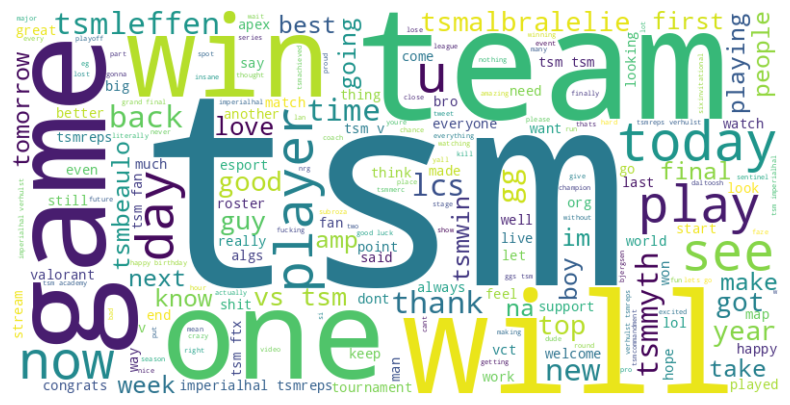

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'tweet' column contains the text data
text_data = ' '.join(train['Tweet'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Bi-Gram Cloud

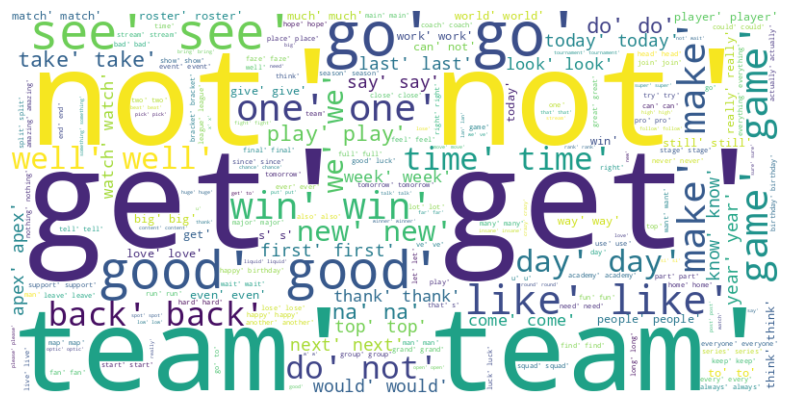

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'bigrams' column contains tuples of bigram phrases
bigram_text = ' '.join([' '.join(map(str, bigrams)) for bigrams in train['bigrams']])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(bigram_text)

# Display the bigram word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Tri-Gram Cloud

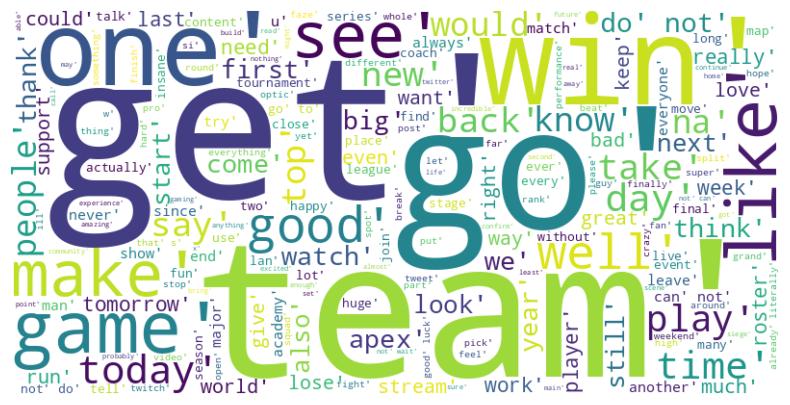

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'trigrams' column contains tuples of trigram phrases
trigram_text = ' '.join([' '.join(map(str, trigrams)) for trigrams in train['trigrams']])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(trigram_text)

# Display the trigram word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis using VADER

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Assuming 'tokenized_tweets' is your tokenized tweets column in DataFrame 'df'
# Replace 'df' and 'tokenized_tweets' with your actual DataFrame and column names

# Function to calculate sentiment scores
def get_sentiment_scores(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

# Assuming you have your lemmatized tweets in a column 'lemmatized_tweets' of your DataFrame 'train'

# Initialize the VADER SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to get sentiment scores
def get_sentiment_scores(text):
    # Join the list of lemmatized words into a single string
    text = ' '.join(text)
    sentiment = analyzer.polarity_scores(text)
    return sentiment

# Apply sentiment analysis to the tokenized tweets column and create a new column for sentiment scores
train['sentiment_scores'] = train['lemmatized_tweets'].apply(get_sentiment_scores)

In [ ]:
# Extract the compound sentiment score, which is a normalized compound score between -1 (negative) and 1 (positive)
train['compound_score'] = train['sentiment_scores'].apply(lambda x: x['compound'])

In [ ]:
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets,pos_tags,noun_phrases,noun_phrases_text,bigrams,trigrams,tfidf_text,sentiment_scores,compound_score
70395,2022-01-24 03:41:45+00:00,hegelfps tsm tsmreps verhulst imperialhal pla...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[hegelfps, 1Mythos, TSM, TSM_Reps, Verhulst, I...",[],"[ratio, aint, game, tho]","[ratio, be, not, game, tho]","[(ratio, NOUN), (be, VERB), (not, PART), (game...","[[ratio], [game, tho]]","[ratio, game tho]","[(ratio, be), (be, not), (not, game), (game, t...","[(ratio, be, not), (be, not, game), (not, game...",ratio be not game tho,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
64690,2022-07-07 17:23:58+00:00,tsmalbralelie i hope you get good results,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM_Albralelie],[],"[hope, get, good]","[hope, get, good]","[(hope, PROPN), (get, VERB), (good, ADJ)]",[],[],"[(hope, get), (get, good)]","[(hope, get, good)]",hope get good,"{'neg': 0.0, 'neu': 0.147, 'pos': 0.853, 'comp...",0.7003
67536,2022-03-27 13:17:10+00:00,tsmleffen even when he gets a dog he still pic...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM_Leffen],[],"[even, dog, still, fox]","[even, dog, still, fox]","[(even, ADV), (dog, NOUN), (still, ADV), (fox,...",[[dog]],[dog],"[(even, dog), (dog, still), (still, fox)]","[(even, dog, still), (dog, still, fox)]",even dog still fox,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
68995,2022-02-20 21:08:37+00:00,twiiztt tsm dw i saw the script,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[Twiiztt, TSM]",[],"[saw, script]","[see, script]","[(see, VERB), (script, NOUN)]",[[script]],[script],"[(see, script)]",[],see script,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
63443,2022-08-25 17:37:34+00:00,wake up tsm is playing today,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[wake, today]","[wake, today]","[(wake, VERB), (today, NOUN)]",[[today]],[today],"[(wake, today)]",[],wake today,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
62925,2022-09-20 16:16:46+00:00,thread nal stage stats i will not claim to kn...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[thread, stage, claim, know, closely, know, st...","[thread, stage, claim, know, closely, know, st...","[(thread, NOUN), (stage, NOUN), (claim, NOUN),...","[[thread, stage, claim], [attack], [table], [t...","[thread stage claim, attack, table, theme atta...","[(thread, stage), (stage, claim), (claim, know...","[(thread, stage, claim), (stage, claim, know),...",thread stage claim know closely know still att...,"{'neg': 0.201, 'neu': 0.388, 'pos': 0.411, 'co...",0.7579
66039,2022-05-12 17:08:20+00:00,tsm subroza content incoming,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM, Subroza]",[],"[content, incoming]","[content, income]","[(content, PROPN), (income, NOUN)]",[[income]],[income],"[(content, income)]",[],content income,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
65473,2022-06-01 22:18:10+00:00,i swear on my mom that come june ill never pl...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[swear, come, june, ill, never, play, worse, t...","[swear, come, june, ill, never, play, bad, tou...","[(swear, PROPN), (come, VERB), (june, PROPN), ...",[[tournament]],[tournament],"[(swear, come), (come, june), (june, ill), (il...","[(swear, come, june), (come, june, ill), (june...",swear come june ill never play bad tournament ...,"{'neg': 0.435, 'neu': 0.36, 'pos': 0.205, 'com...",-0.2928
63460,2022-08-25 03:17:17+00:00,tsm we love you,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],[love],[love],"[(love, NOUN)]",[[love]],[love],[],[],love,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.6369
69149,2022-02-19 23:02:29+00:00,happy for tsm but damn cannot believe imt lost...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[happy, damn, believe, l

## PCA & K-Means Clustering

In [ ]:
# new code: try to fix the double-row error in compound process
compound_score_df = train['compound_score'].reset_index(drop=True).to_frame()
tfidf_df_reset = tfidf_df.reset_index(drop=True)

In [ ]:
# Combine sentiment scores and TF-IDF vectors
# new code: change tfidf_df to tfidf_df_reset due to last row's new code
X = pd.concat([compound_score_df, tfidf_df_reset], axis=1)

In [ ]:
print("Shape after concatenation:", X.shape)

Shape after concatenation: (11034, 5205)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

In [ ]:
# Step 1: Determine the Number of Components for PCA
explained_variance_threshold = 0.95  # Set your desired threshold

# Initialize the imputer
imputer = SimpleImputer(strategy='mean')  # You can also try 'median' or 'most_frequent'

# Initialize PCA
pca = PCA()

# Fit PCA to your TF-IDF matrix
pca.fit(X)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Find the optimal number of components
optimal_components = np.argmax(cumulative_explained_variance >= explained_variance_threshold) + 1

In [ ]:
optimal_components

2243

In [ ]:
# Step 2: Perform PCA
pca = PCA(n_components=optimal_components)
X_pca = pca.fit_transform(X)

In [ ]:
# Step 3: Determine the Number of Clusters for K-Means
# Use the Elbow Method to find the optimal number of clusters
inertia = []
max_clusters = 10  # Adjust the maximum number of clusters as needed

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

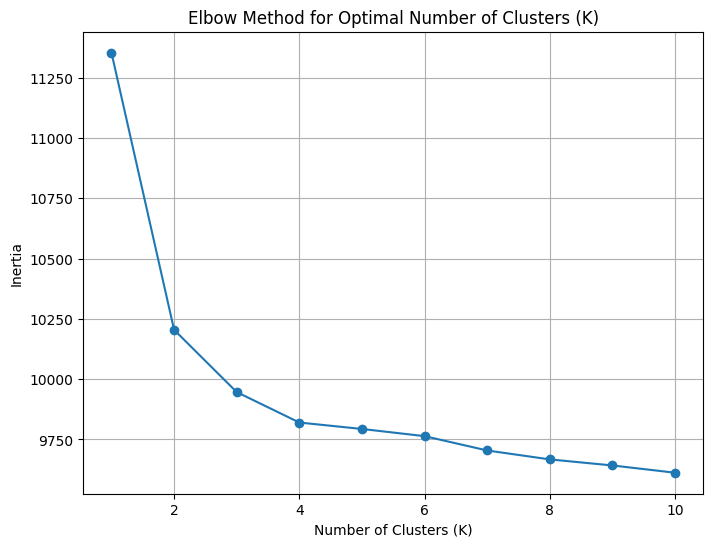

In [ ]:
# Plot the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [ ]:
# Choose the optimal number of clusters based on the Elbow Method
optimal_clusters = 3  # Set the optimal number of clusters

# Step 4: Perform K-Means Clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

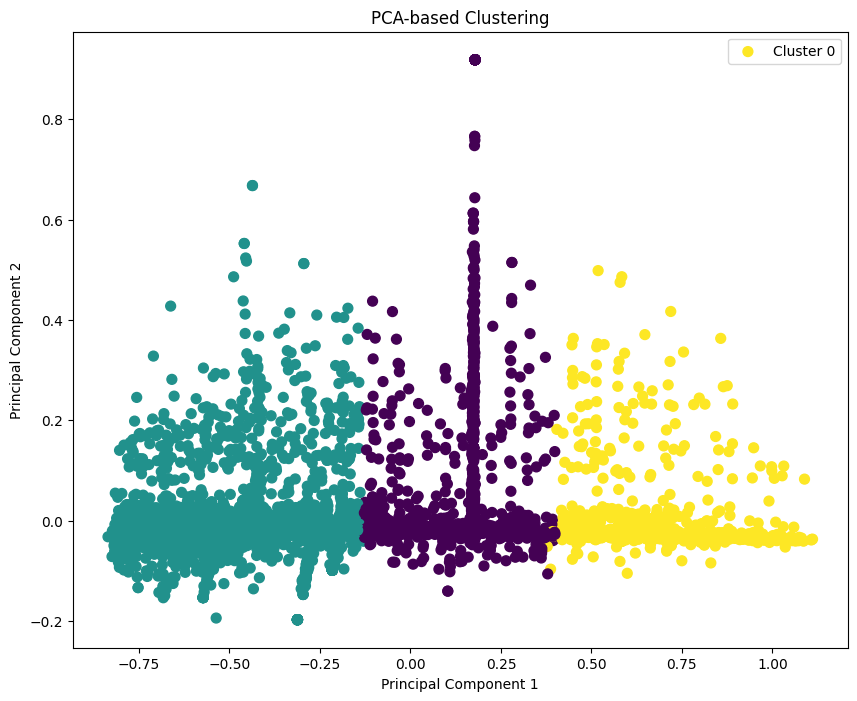

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot of the PCA-reduced data points with cluster colors
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=50)  # Adjust the size (s) as needed
plt.title('PCA-based Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add legend
legend_labels = [f'Cluster {i}' for i in range(optimal_clusters)]
plt.legend(legend_labels, loc='upper right')

plt.show()

In [ ]:
# Choose the optimal number of clusters based on the Elbow Method
optimal_clusters = 4  # Set the optimal number of clusters

# Step 4: Perform K-Means Clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

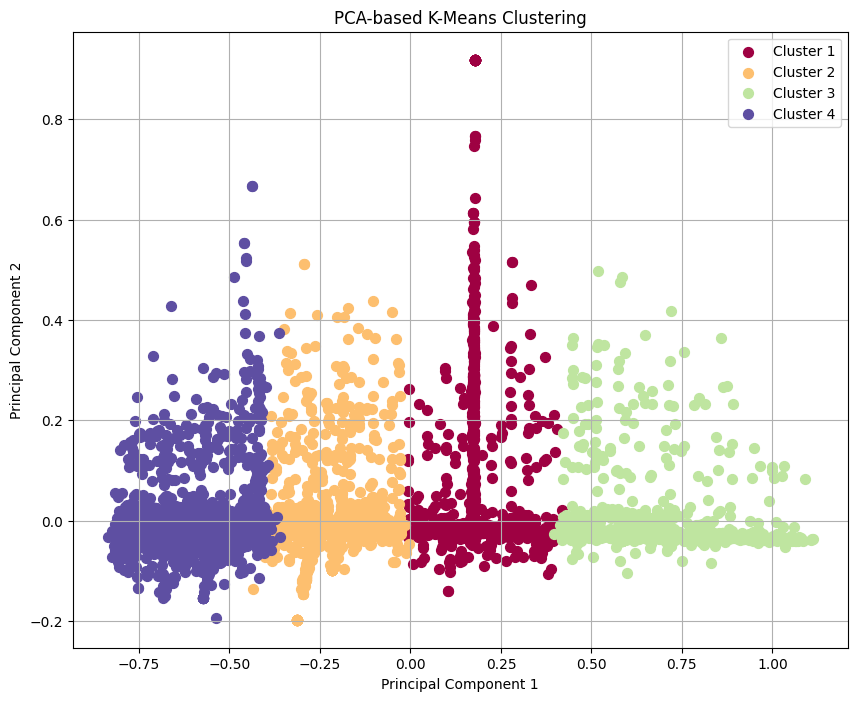

In [ ]:
# Scatter plot of the clustering results
plt.figure(figsize=(10, 8))
colors = plt.cm.Spectral(np.linspace(0, 1, optimal_clusters))

for cluster_num in range(optimal_clusters):
    cluster_points = X_pca[cluster_labels == cluster_num]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=50, c=colors[cluster_num], label=f'Cluster {cluster_num + 1}')

plt.title("PCA-based K-Means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score
silhouette_avg = silhouette_score(X_pca, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.04765945703828427


In [ ]:
print("Original DataFrame shape:", train.shape)
print("Shape after PCA:", X_pca.shape)

Original DataFrame shape: (11034, 17)
Shape after PCA: (11034, 2243)


In [ ]:
# Add K-Means cluster labels to your DataFrame
train['kmeans_clusters'] = cluster_labels

In [ ]:
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets,pos_tags,noun_phrases,noun_phrases_text,bigrams,trigrams,tfidf_text,sentiment_scores,compound_score,kmeans_clusters
69173,2022-02-19 16:30:38+00:00,gamechangers is mvp of the vs tsm coinchan...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[Dan_R6, TSM, coinchangeio]","[rainbow6, SI2022, gamechangers]",[],[],[],[],[],[],[],,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,0
67241,2022-04-06 17:03:00+00:00,sentinels misfitsgg zetadivision fazeclan ko...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[Sentinels, crazyraccoon406, MisfitsGG, zetadi...",[],"[koi, ten, highest, amount, brazil, heavily, e...","[koi, ten, high, amount, brazil, heavily, enga...","[(koi, NOUN), (ten, NUM), (high, ADJ), (amount...","[[koi, ten], [amount], [posting, cadence], [tw...","[koi ten, amount, posting cadence, twitter str...","[(koi, ten), (ten, high), (high, amount), (amo...","[(koi, ten, high), (ten, high, amount), (high,...",koi ten high amount brazil heavily engage high...,"{'neg': 0.0, 'neu': 0.862, 'pos': 0.138, 'comp...",0.3400,1
69300,2022-02-17 00:08:57+00:00,fudgecakey gave berserker spaghetti and he is...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[Fudgecakey],[],"[gave, berserker, spaghetti, well, give, spagh...","[give, berserker, spaghetti, well, give, spagh...","[(give, VERB), (berserker, NOUN), (spaghetti, ...","[[berserker, spaghetti], [spaghetti]]","[berserker spaghetti, spaghetti]","[(give, berserker), (berserker, spaghetti), (s...","[(give, berserker, spaghetti), (berserker, spa...",give berserker spaghetti well give spaghetti,"{'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'comp...",0.2732,1
69708,2022-02-08 00:38:34+00:00,imperialhal lay the law baby,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[ImperialHal],[],"[lay, law, baby]","[lie, law, baby]","[(lie, NOUN), (law, NOUN), (baby, NOUN)]","[[lie, law, baby]]",[lie law baby],"[(lie, law), (law, baby)]","[(lie, law, baby)]",lie law baby,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0
71414,2021-12-10 03:34:47+00:00,tsm tsmshenyi take care shenyi hope we can reu...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[TSM, tsm_shenyi]",[],"[take, care, hope, reunite, next, year]","[take, care, hope, reunite, next, year]","[(take, VERB), (care, NOUN), (hope, NOUN), (re...","[[care, hope], [year]]","[care hope, year]","[(take, care), (care, hope), (hope, reunite), ...","[(take, care, hope), (care, hope, reunite), (h...",take care hope reunite next year,"{'neg': 0.0, 'neu': 0.396, 'pos': 0.604, 'comp...",0.7269,3
63754,2022-08-10 20:08:18+00:00,guiiimond tsmdaeda they blast packed in,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[Guiiimond, TSM_Daeda]",[],[blast],[blast],"[(blast, NOUN)]",[[blast]],[blast],[],[],blast,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0
67082,2022-04-13 23:57:35+00:00,my boy roman just had quite literally the grea...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[boy, quite, literally, performance, ever, his...","[boy, quite, literally, performance, ever, his...","[(boy, INTJ), (quite, ADV), (literally, ADV), ...","[[history, coincidence], [workout, week], [king]]","[history coincidence, workout week, king]","[(boy, quite), (quite, literally), (literally,...","[(boy, quite, literally), (quite, literally, p...",boy quite literally performance ever history c...,"{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'comp...",0.6369,3
63267,2022-09-02 18:25:27+00:00,soniqsesports tsmgeometrics congrats boys,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[SoniqsEsports, TSM_Geometrics, Gunnar_r6]",[],[],[],[],[],[],[],[],,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,0
63131,2022-09-07 01:25:57+00:00,lets fucking go skqttlescuh ajerss tsmcommand...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[skqttlescuh, Ajerss, TSM_Commandment]",[],[go],[go],"[(go, VERB)

## Fuzzy C Means Clustering

In [ ]:
pip install scikit-fuzzy

In [ ]:
import numpy as np
import skfuzzy as fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Assuming you have your sentiment score column as 'sentiment_scores' and TF-IDF matrix in 'X'

# Step 1: Standardize your TF-IDF matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Step 2: Determine the Number of Clusters for Fuzzy C-Means
# Use the Fuzzy C-Means algorithm with varying cluster counts and select the optimal number of clusters
max_clusters = 10  # Adjust the maximum number of clusters as needed
best_silhouette_score = -1
optimal_clusters = 2  # Default to 2 clusters if no better option is found

for n_clusters in range(2, max_clusters + 1):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X_scaled.T, c=n_clusters, m=2, error=0.005, maxiter=1000, seed=0)
    cluster_membership = np.argmax(u, axis=0)
    silhouette_avg = silhouette_score(X_scaled, cluster_membership)
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        optimal_clusters = n_clusters

In [ ]:
# Step 3: Perform Fuzzy C-Means Clustering with the Optimal Number of Clusters
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X_scaled.T, c=optimal_clusters, m=2, error=0.005, maxiter=1000, seed=0)
cluster_membership = np.argmax(u, axis=0)

In [ ]:
# 'cluster_membership' now contains the cluster labels for each data point

# You can add the cluster labels to your DataFrame if needed
train['fuzzy_cmeans_clusters'] = cluster_membership

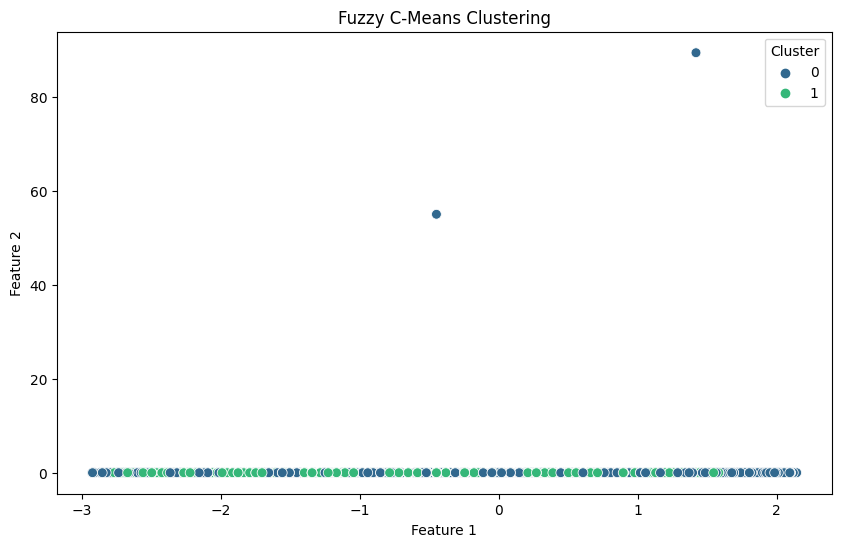

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'cluster_membership' contains the cluster memberships obtained from the fuzzy C-Means clustering

# Create a scatter plot to visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=cluster_membership, palette='viridis', s=50)
plt.title("Fuzzy C-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Step 4: Evaluate Fuzzy C-Means Clustering
# Fuzzy Partition Coefficient (FPC)
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")

# Silhouette Score
silhouette_avg = silhouette_score(X_scaled, cluster_membership)
print(f"Silhouette Score: {silhouette_avg}")

Fuzzy Partition Coefficient (FPC): 0.500000000012114
Silhouette Score: 0.05501506810209854


## Agglomerative Hierarchical Clustering

In [ ]:
import numpy as np

# Assuming you have a DataFrame named 'X' with your data
# Replace 'X' with the actual variable name holding your dataset

# Specify the sample size you want to select
sample_size = 5000

# Generate random indices within the range of your DataFrame's shape
random_indices = np.random.choice(X.shape[0], sample_size, replace=True)

# Use the random indices to select the corresponding rows from your DataFrame
sub_X = X.iloc[random_indices]

# Now, 'sub_X' contains a random subset of rows from your original DataFrame 'X'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming you have your sentiment score column as 'sentiment_scores' and TF-IDF matrix in 'X'

# Step 1: Create a linkage matrix using your TF-IDF matrix
linkage_matrix = linkage(sub_X, method='ward')  # You can choose a different linkage method if needed

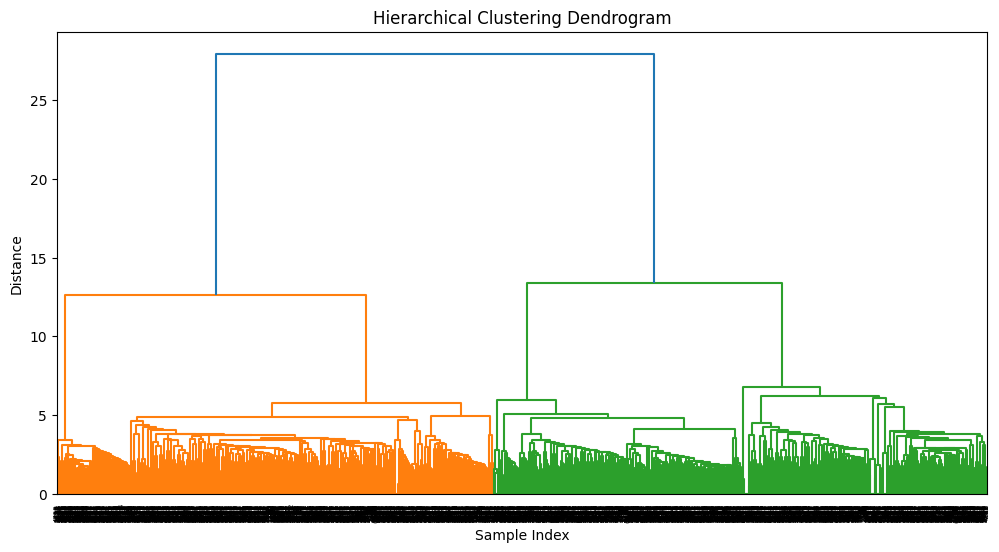

In [ ]:
# Step 2: Plot the Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, p=30, truncate_mode='level')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Example: Determine the optimal number of clusters using the dendrogram
max_d = 50  # Set a maximum distance threshold for cutting the dendrogram
optimal_clusters = len(np.unique(fcluster(linkage_matrix, max_d, criterion='distance')))

In [ ]:
# Step 4: Perform Hierarchical Clustering with the Optimal Number of Clusters
cluster_assignments = fcluster(linkage_matrix, max_d, criterion='distance')

## Stock Prediction using Sentiment Analysis & Generative Adversarial Network

In [ ]:
train['tweets'] = dataset['Tweet']

In [ ]:
train.head()

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets,pos_tags,noun_phrases,noun_phrases_text,bigrams,trigrams,tfidf_text,sentiment_scores,compound_score,kmeans_clusters,fuzzy_cmeans_clusters,tweets
62741,2022-09-29 22:23:02+00:00,eg vs fnc is a deadly matchup eg using their s...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[deadly, cutting, studio, audio, night, delay,...","[deadly, cut, studio, audio, night, delay, inf...","[(deadly, ADJ), (cut, VERB), (studio, NOUN), (...","[[studio, audio, night], [pause], [league]]","[studio audio night, pause, league]","[(deadly, cut), (cut, studio), (studio, audio)...","[(deadly, cut, studio), (cut, studio, audio), ...",deadly cut studio audio night delay infinitely...,"{'neg': 0.328, 'neu': 0.672, 'pos': 0.0, 'comp...",-0.5267,2,0,EG vs FNC is a deadly matchup.\n\nEG using the...
62742,2022-09-29 21:50:16+00:00,btssmash coinbase pandaplup liquidhbox tsmleff...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[],"[ken, seething]","[ken, seething]","[(ken, PROPN), (seething, PROPN)]",[],[],"[(ken, seething)]",[],ken seething,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0,1,@BTSsmash @coinbase @Panda_Plup @LiquidHbox @T...
62743,2022-09-29 21:13:20+00:00,i keep looking at the current standings and i...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[SoniqsEsports, TSM, XSET, MirageSportE, DarkZ...",[R6NAL],"[keep, looking, current, still, believe, seein...","[keep, look, current, still, believe, see, any...","[(keep, VERB), (look, VERB), (current, ADJ), (...",[],[],"[(keep, look), (look, current), (current, stil...","[(keep, look, current), (look, current, still)...",keep look current still believe see anything h...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0,0,I keep looking at the current #R6NAL standings...
62744,2022-09-29 19:35:26+00:00,btssmash coinbase pandaplup liquidhbox tsmleff...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[BTSsmash, coinbase, Panda_Plup, LiquidHbox, T...",[],[cool],[cool],"[(cool, ADJ)]",[],[],[],[],cool,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.3182,1,1,@BTSsmash @coinbase @Panda_Plup @LiquidHbox @T...
62745,2022-09-29 19:19:05+00:00,btssmash coinbase pandaplup liquidhbox tsmlef...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[joe1chief, BTSsmash, coinbase, Panda_Plup, Li...",[],"[could, come, last, summit, covid]","[could, come, last, summit, covid]","[(could, AUX), (come, VERB), (last, ADJ), (sum...","[[summit, covid]]",[summit covid],"[(could, come), (come, last), (last, summit), ...","[(could, come, last), (come, last, summit), (l...",could come last summit covid,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0,0,@joe1chief @BTSsmash @coinbase @Panda_Plup @Li...


In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to get sentiment scores
def get_sentiment_scores(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment

# Apply sentiment analysis to the 'text' column and create new columns for sentiment scores
train['sentiment_scores'] = train['tweets'].apply(get_sentiment_scores)

# Extract the compound sentiment score
train['compound_score'] = train['sentiment_scores'].apply(lambda x: x['compound'])

In [ ]:
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets,pos_tags,noun_phrases,noun_phrases_text,bigrams,trigrams,tfidf_text,sentiment_scores,compound_score,kmeans_clusters,fuzzy_cmeans_clusters,tweets
70965,2021-12-31 17:32:22+00:00,tsm yall cloned snipedowns amp made a halo team,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM],[],"[made, halo, team]","[make, halo, team]","[(make, VERB), (halo, NOUN), (team, NOUN)]","[[halo, team]]",[halo team],"[(make, halo), (halo, team)]","[(make, halo, team)]",make halo team,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0,1,@TSM Y’all cloned 3 snipedowns &amp; made a ha...
67586,2022-03-26 01:52:51+00:00,with that loss we are eliminated for lcs sprin...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[loss, spring, thanks, cheering, us]","[loss, spring, thank, cheer, we]","[(loss, NOUN), (spring, NOUN), (thank, NOUN), ...","[[loss, spring, thank, cheer]]",[loss spring thank cheer],"[(loss, spring), (spring, thank), (thank, chee...","[(loss, spring, thank), (spring, thank, cheer)...",loss spring thank cheer we,"{'neg': 0.107, 'neu': 0.605, 'pos': 0.288, 'co...",0.5994,1,0,"With that loss, we are eliminated for LCS Spri..."
70131,2022-01-30 03:54:05+00:00,ggs to tsm we lose we play the lower brack...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM],[],"[lose, play, lower, bracket, tomorrow]","[lose, play, low, bracket, tomorrow]","[(lose, VERB), (play, VERB), (low, ADJ), (brac...","[[bracket, tomorrow]]",[bracket tomorrow],"[(lose, play), (play, low), (low, bracket), (b...","[(lose, play, low), (play, low, bracket), (low...",lose play low bracket tomorrow,"{'neg': 0.241, 'neu': 0.64, 'pos': 0.118, 'com...",-0.3612,2,1,ggs to @TSM we lose 1-2 (7-5 4-7 4-7). We play...
65318,2022-06-09 16:06:21+00:00,valorantupdated wheres that credit at,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[ValorantUpdated],[],[credit],[credit],"[(credit, NOUN)]",[[credit]],[credit],[],[],credit,"{'neg': 0.0, 'neu': 0.584, 'pos': 0.416, 'comp...",0.5514,1,1,@ValorantUpdated Where’s that credit at?????? ...
72735,2021-11-01 20:45:45+00:00,hazedcs tsm sorry i left you on read yes we ca...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[hazedCS, TSM]",[],"[sorry, left, read, yes, play]","[sorry, left, read, yes, play]","[(sorry, INTJ), (left, ADJ), (read, VERB), (ye...",[],[],"[(sorry, left), (left, read), (read, yes), (ye...","[(sorry, left, read), (left, read, yes), (read...",sorry left read yes play,"{'neg': 0.09, 'neu': 0.556, 'pos': 0.354, 'com...",0.5859,3,1,"@hazedCS @TSM sorry i left you on read, yes we..."
73412,2021-10-12 16:09:07+00:00,beaulo better carry me to champ for that order...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[],[],"[better, carry, champ, order, merch, sexy, man]","[well, carry, champ, order, merch, sexy, man]","[(well, INTJ), (carry, VERB), (champ, NOUN), (...","[[champ, order, merch], [man]]","[champ order merch, man]","[(well, carry), (carry, champ), (champ, order)...","[(well, carry, champ), (carry, champ, order), ...",well carry champ order merch sexy man,"{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...",0.8555,3,0,Beaulo better carry me to champ for that order...
65214,2022-06-14 17:20:58+00:00,todays updated schedule darkzerogg vs beastco...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"[DarkZeroGG, beastcoast, Astralisgg, SoniqsEsp...",[R6NAL],"[schedule, let, stage, begin]","[schedule, let, stage, begin]","[(schedule, NOUN), (let, VERB), (stage, NOUN),...","[[schedule], [stage]]","[schedule, stage]","[(schedule, let), (let, stage), (stage, begin)]","[(schedule, let, stage), (let, stage, begin)]",schedule let stage begin,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0,1,Today's updated #R6NAL schedule:\n\n@DarkZeroG...
71863,2021-11-22 17:00:18+00:00,tsmzexrow you were bad lol,TSM,Taiwan Semiconductor Manufacturing Company Lim...,[TSM_ZexRow],[],[bad],[

In [ ]:
# new code-visualize the compound score

import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Assuming 'train' is your DataFrame and 'compound_score' is the column of interest

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(train['compound_score'], bins=30, kde=False)
plt.title('Histogram of Compound Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.show()

# Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(train['compound_score'], fill=True)
plt.title('Density Plot of Compound Scores')
plt.xlabel('Compound Score')
plt.ylabel('Density')
plt.show()

TypeError: ignored

<Figure size 1000x600 with 0 Axes>

In [ ]:
stock_tweets = train[['Date','compound_score']]

In [ ]:
stock_tweets.sample(10)

,Date,compound_score
66646,2022-04-28 20:11:47+00:00,0.1280
73107,2021-10-21 22:51:20+00:00,0.4939
69952,2022-02-01 17:00:52+00:00,-0.2500
73172,2021-10-20 17:01:14+00:00,-0.8271
69608,2022-02-10 17:55:49+00:00,0.0000
65552,2022-05-27 19:12:18+00:00,0.0000
68222,2022-03-06 17:00:06+00:00,-0.5423
72891,2021-10-28 21:55:46+00:00,0.0000
64722,2022-07-06 23:31:42+00:00,0.4802
62964,2022-09-17 03:43:46+00:00,0.4215


In [ ]:
stock_tweets.shape

(11034, 2)

In [ ]:
stock_tweets['Date'] = pd.to_datetime(stock_tweets['Date'])
stock_tweets['Date'] = stock_tweets['Date'].dt.date

In [ ]:
stock_tweets.head()

,Date,compound_score
62741,2022-09-29,-0.4215
62742,2022-09-29,0.0000
62743,2022-09-29,0.4404
62744,2022-09-29,0.3182
62745,2022-09-29,-0.4404


In [ ]:
stock_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11034 entries, 62741 to 73774
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            11034 non-null  object 
 1   compound_score  11034 non-null  float64
dtypes: float64(1), object(1)
memory usage: 516.6+ KB


In [ ]:
twitter_df = stock_tweets.groupby([stock_tweets['Date']]).mean()
print(twitter_df.shape)

(365, 1)


In [ ]:
twitter_df.sample(10)

,compound_score
Date,
2022-07-09,0.240826
2022-07-27,0.161626
2021-12-08,0.141497
2022-07-18,0.112093
2021-10-09,0.040025
2022-08-20,0.145371
2022-06-24,0.136305
2022-07-05,0.208171
2022-06-29,0.278958


In [ ]:
stocks = pd.read_csv('/content/drive/MyDrive/5067 NLP/stock_yfinance_data.csv')
print(stocks.shape)
stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [ ]:
stock_name = 'TSM'
stock_df = stocks[stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [ ]:
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
2268,2021-09-30,112.430000,113.349998,111.650002,111.650002,109.457535,6433400,TSM
2269,2021-10-01,112.000000,112.300003,110.300003,111.559998,109.369293,5315200,TSM
2270,2021-10-04,111.000000,111.430000,108.519997,109.019997,106.879173,8514500,TSM
2271,2021-10-05,109.800003,110.349998,109.220001,109.260002,107.114464,8039600,TSM
2272,2021-10-06,108.440002,109.519997,107.580002,109.339996,107.192886,7553600,TSM


In [ ]:
stock_df.shape

(252, 8)

In [ ]:
final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(252, 8)


In [ ]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,compound_score
2268,2021-09-30,112.430000,113.349998,111.650002,111.650002,109.457535,6433400,0.383726
2269,2021-10-01,112.000000,112.300003,110.300003,111.559998,109.369293,5315200,0.230249
2270,2021-10-04,111.000000,111.430000,108.519997,109.019997,106.879173,8514500,0.061684
2271,2021-10-05,109.800003,110.349998,109.220001,109.260002,107.114464,8039600,0.149810
2272,2021-10-06,108.440002,109.519997,107.580002,109.339996,107.192886,7553600,0.212018


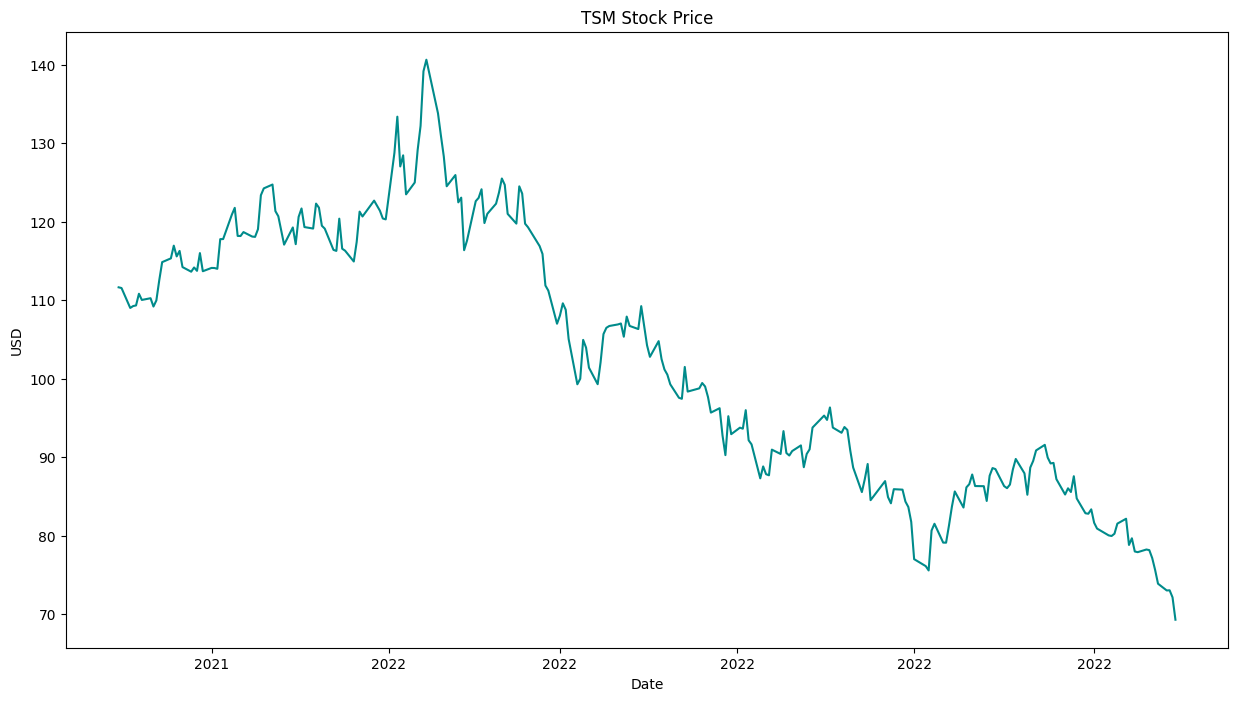

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter  # Import DateFormatter

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

## Adding technical indicators

MA(7) stans for Moving Average for past 7 days, whereas MA(20) means Moving Average for past 20 days.

EMA is Exponential Moving average and we can calculate it as:

EMA_t = Pclose + (EMA_t-1 (100 - P))* Bollinger Bands are calculated as:

middle line: stdev(MA(20)) upper bound: MA(20) + 2stdev(MA(20)) lower bound: MA(20) - 2stdev(MA(20))

In [ ]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [ ]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,compound_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,113.660004,116.019997,113.540001,116.010002,113.731911,5714300,0.163428,114.812857,112.6450,-0.593961,2.739528,118.124057,107.165943,115.299548,4.745019
1,2021-10-29,114.070000,114.190002,113.220001,113.699997,111.467270,7118900,0.270117,114.542858,112.7520,-0.573929,2.736711,118.225421,107.278578,114.233181,4.724729
2,2021-11-01,113.580002,114.339996,113.349998,114.120003,111.879028,4955700,0.112756,114.232858,113.0070,-0.443097,2.605108,118.217217,107.796783,114.157729,4.728449
3,2021-11-02,113.589996,114.800003,113.540001,114.110001,111.869225,4479700,0.253340,114.215715,113.2495,-0.331955,2.459629,118.168757,108.330243,114.125910,4.728361
4,2021-11-03,113.440002,114.099998,112.730003,114.010002,111.771179,6073000,0.092983,114.268572,113.4830,-0.220870,2.284379,118.051759,108.914242,114.048638,4.727476


In [ ]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

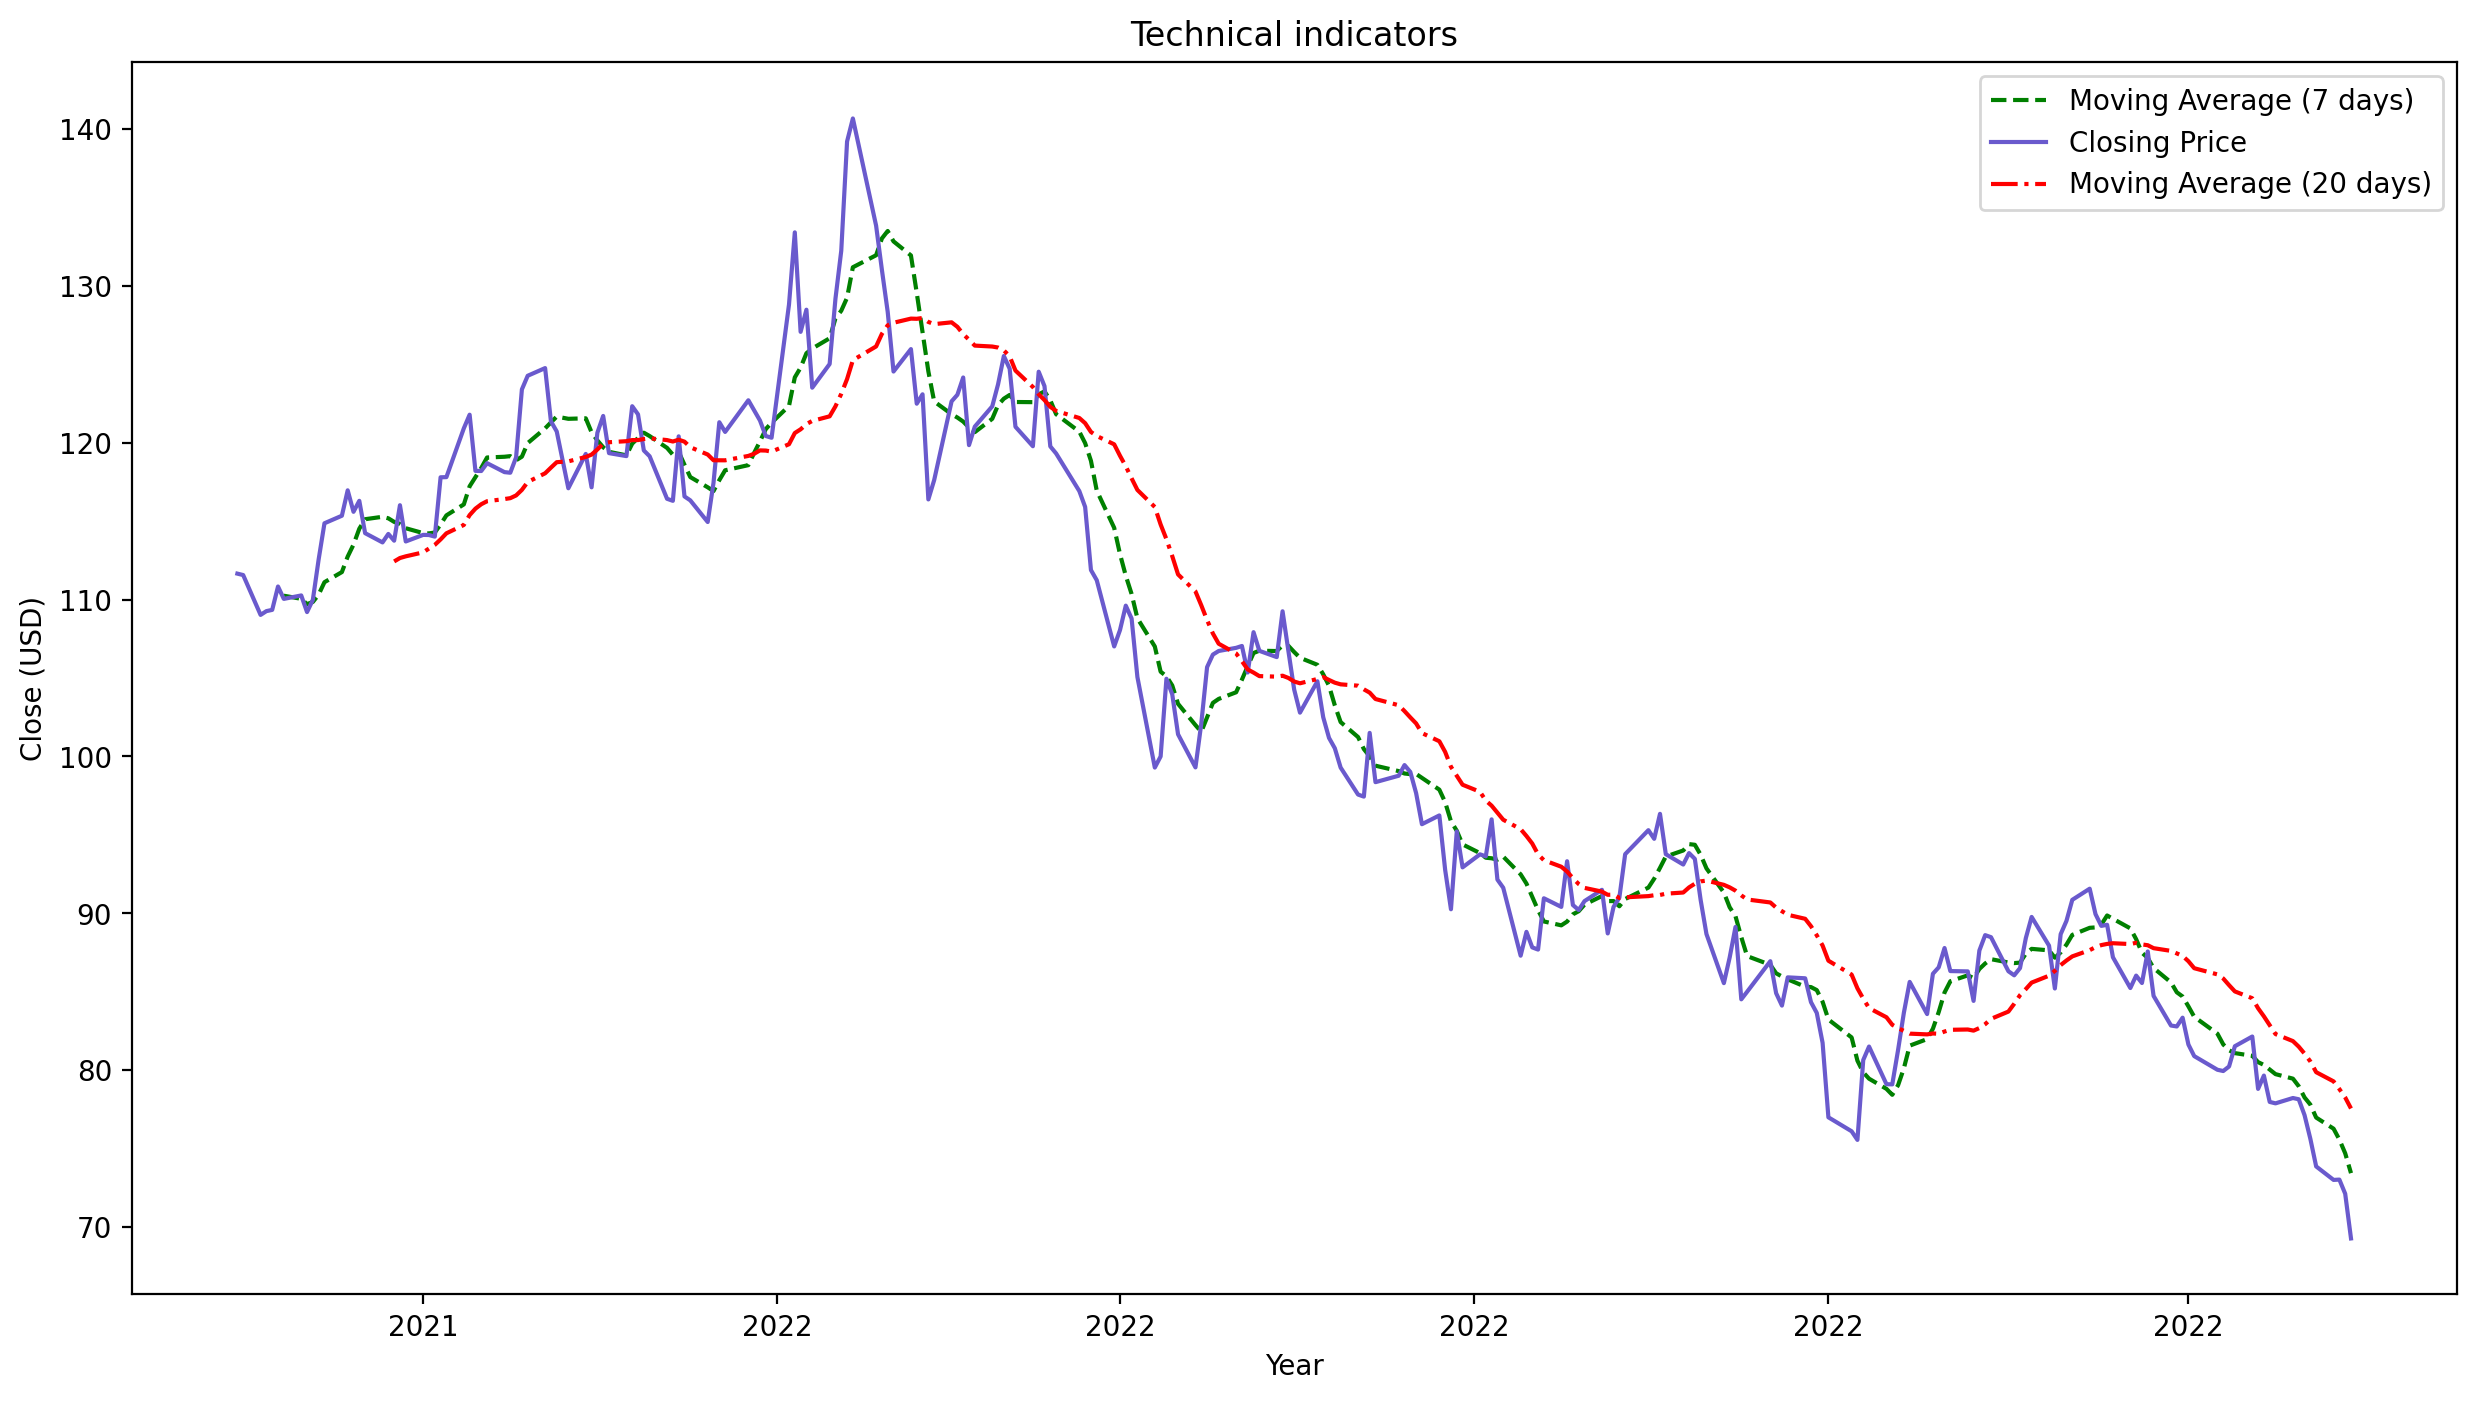

In [ ]:
tech_ind(tech_df)

In [ ]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [ ]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [ ]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [ ]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [ ]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [ ]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [ ]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pickle  # Import the pickle module

X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 15)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [ ]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]


## Build GAN model

In [ ]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True,
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

In [ ]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    #cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [ ]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [ ]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [ ]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())

        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)

    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [ ]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

In [ ]:
## Test Code

@tf.function

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [ ]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
    plt.show()

In [ ]:
learning_rate = 5e-4
epochs = 500

g_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])

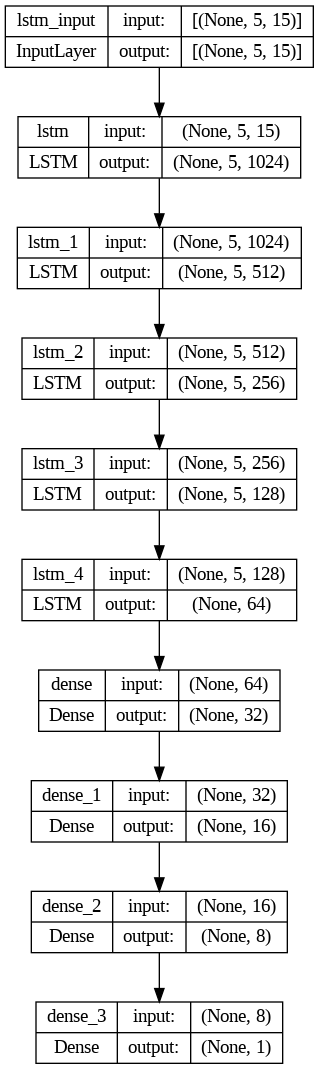

In [ ]:
plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)

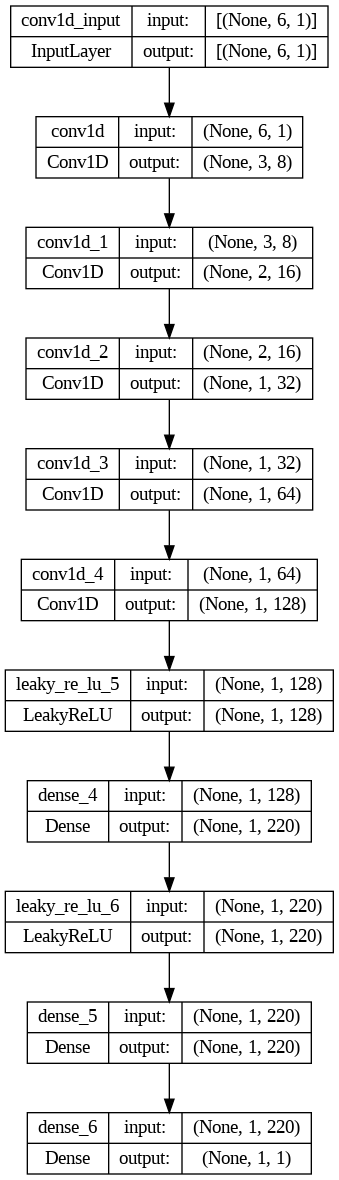

In [ ]:
tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)

## Train and test model

 10%|█         | 50/500 [02:10<13:58,  1.86s/it]

epoch 50 discriminator_loss 1.3911284 generator_loss 0.6808375


 20%|██        | 100/500 [04:00<12:37,  1.89s/it]

epoch 100 discriminator_loss 1.3869734 generator_loss 0.69223416


 30%|███       | 150/500 [05:42<11:23,  1.95s/it]

epoch 150 discriminator_loss 1.3871738 generator_loss 0.6925248


 40%|████      | 200/500 [07:27<10:38,  2.13s/it]

epoch 200 discriminator_loss 1.385792 generator_loss 0.68592584


 50%|█████     | 250/500 [09:35<12:03,  2.90s/it]

epoch 250 discriminator_loss 1.3874605 generator_loss 0.6880484


 60%|██████    | 300/500 [11:18<07:08,  2.14s/it]

epoch 300 discriminator_loss 1.386271 generator_loss 0.6996863


 70%|███████   | 350/500 [13:01<04:57,  1.98s/it]

epoch 350 discriminator_loss 1.387156 generator_loss 0.6969973


 80%|████████  | 400/500 [14:43<03:46,  2.27s/it]

epoch 400 discriminator_loss 1.3865821 generator_loss 0.6831195


 90%|█████████ | 450/500 [16:27<01:39,  1.99s/it]

epoch 450 discriminator_loss 1.386794 generator_loss 0.68472606


100%|██████████| 500/500 [18:14<00:00,  2.19s/it]


epoch 500 discriminator_loss 1.3869064 generator_loss 0.69636726


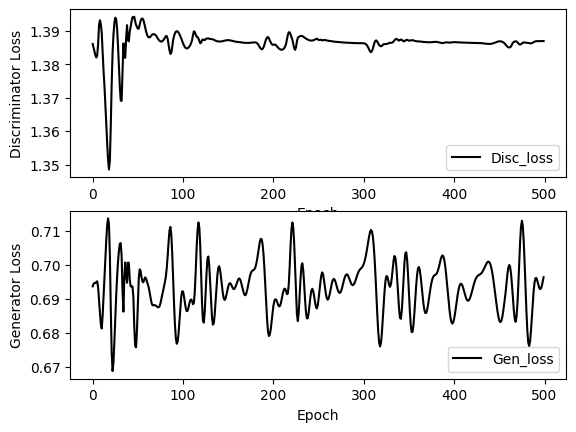

In [ ]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [ ]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')

Test RMSE:  9.123900007980367


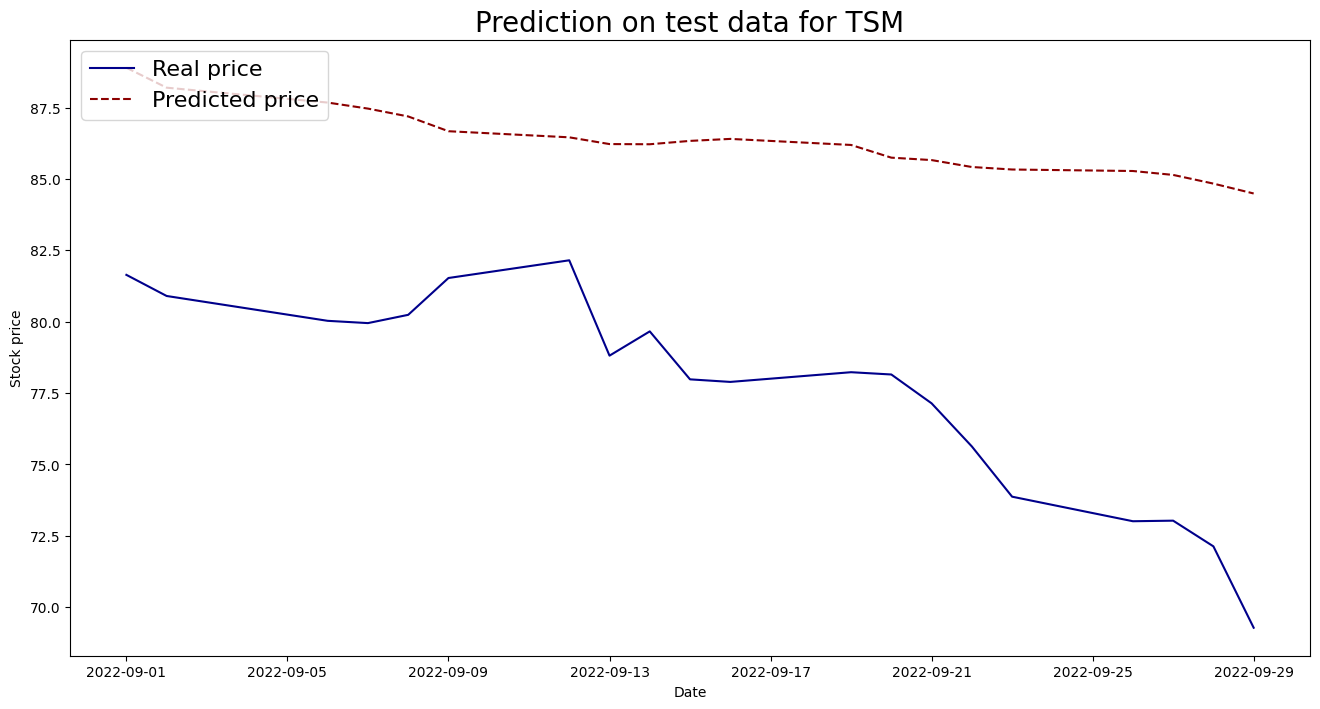

In [ ]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)

## Conclusions